In [10]:
import os, pickle, time, re, sys, operator

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import auc, classification_report, roc_auc_score, f1_score, matthews_corrcoef, balanced_accuracy_score, r2_score , confusion_matrix, precision_score, recall_score

import pandas as pd
import numpy as np
import seaborn as sns

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

# from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt


from datetime import datetime
from collections import Counter


sys.path.append(os.path.abspath('../'))
from pyexplainer.pyexplainer_pyexplainer import PyExplainer

from IPython.display import display

In [11]:
data_path = './dataset/'
result_dir = './new_eval_result/'
dump_dataframe_dir = './dump_df/'
# pyExp_dir = './pyExplainer_obj/'
pyExp_dir = './explainer_obj_20_4_2021/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [12]:
# def test_lime(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     all_eval_result = pd.DataFrame()
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         # this data can be used for both local and global model
#         py_exp_synthetic_data = py_exp['synthetic_data'].values
#         # this data can be used with global model only
#         lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
#         # this data can be used with local model only
#         lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
#         display(X_explain)
#         display(lime_exp_synthetic_data[:5,:])
#         display(lime_exp_synthetic_data_local[:5,:])
        
#         break
        
# test_lime('openstack')

In [13]:
flip_sign_dict = {
    '<': '>=',
    '>': '<=',
    '=': '!=',
    '>=': '<',
    '<=': '>',
    '!=': '=='
}

'''
    input: rule (str)
'''
def flip_rule(rule):
    rule = re.sub(r'\b=\b',' = ',rule) # for LIME
#     rule = rule.replace('&','and') # for RuleFit
    found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', rule) # for LIME
    ret = ''
    
    # for LIME that has condition like this: 0.53 < nref <= 0.83
    if len(found_rule) > 0:
        found_rule = found_rule[0]
    
        var_in_rule = re.findall('[a-zA-Z]+',found_rule)

        var_in_rule = var_in_rule[0]
        
        splitted_rule = found_rule.split(var_in_rule)
        splitted_rule[0] = splitted_rule[0] + var_in_rule # for left side
        splitted_rule[1] = var_in_rule + splitted_rule[1] # for right side
        combined_rule = splitted_rule[0] + ' or ' + splitted_rule[1]
        ret = flip_rule(combined_rule)
        
    else:
        for tok in rule.split():
            if tok in flip_sign_dict:
                ret = ret + flip_sign_dict[tok] + ' '
            else:
                ret = ret + tok + ' '
    return ret

def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features
    
def sort_global_feature(global_model, indep):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    sorted_global_features = list(global_feature_df['feature'])

    return sorted_global_features

def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
#     print(rule_df)
    top_k = 5
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)
#     top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("coef", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def get_rule_str_of_rulefit_new_version(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    rule_df =  rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False)
    
    rule_list = list(rule_df['rule'])
    dup_feature_in_rule = [] # true or false...
    
    for r in rule_list:
        var_in_rule = re.findall('[a-zA-Z]+', r)
        var_count = Counter(var_in_rule)
        max_count = max(list(var_count.values()))
        
        if max_count > 1:
            dup_feature_in_rule.append(True)
        else:
            dup_feature_in_rule.append(False)
           
    if False not in set(dup_feature_in_rule):
        rule_df = rule_df.head(5)
        the_best_defective_rule_str = list(rule_df['rule'])[0]
        
    else:
        rule_df['contain_dup_var'] = dup_feature_in_rule    
        the_best_defective_rule_str = rule_df[rule_df['contain_dup_var']==False].iloc[0]['rule']
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [14]:
# def test_new_rule_from_rulefit(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     all_eval_result = pd.DataFrame()
    
#     c = 0
    
# #     py_exp_all_rules = []
# #     lime_all_rules = []
#     py_exp_all_vars = []
#     lime_all_vars = []
    
#     print('global feature feature importance ranking:')
#     print(sort_global_feature(global_model, indep))
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
#         py_exp_local_model = py_exp['local_model']
        
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))
        
# #         py_exp_rule = get_rule_str_of_rulefit(py_exp_local_model)
#         py_exp_rule_new = get_rule_str_of_rulefit_new_version(py_exp_local_model)
#         lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

#         py_exp_pred = eval_rule(py_exp_rule_new, X_explain)[0]
#         lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         if py_exp_pred == 1:
#             py_exp_var_in_rule = list(set(re.findall('[a-zA-Z]+', py_exp_rule_new)))
#             py_exp_all_vars.extend(py_exp_var_in_rule)
#         if lime_pred == 1:
#             lime_var_in_rule = list(set(re.findall('[a-zA-Z]+', lime_the_best_defective_rule_str)))
#             lime_all_vars.extend(lime_var_in_rule)
            
# #         py_exp_all_rules.append(py_exp_rule_new)
# #         lime_all_rules.append(lime_the_best_defective_rule_str)
        
# #         eval_result = eval_rule(lime_the_best_defective_rule_str, X_explain)

# #         if eval_result[0]:
# #             c =c+1

    
# #     print(len(set(py_exp_all_rules)))
# #     print(len(set(lime_all_rules)))
    
#     print('pyExplainer var count')
#     print(Counter(py_exp_all_vars))
#     print('-'*100)
#     print('LIME var count')
#     print(Counter(lime_all_vars))
    
# print('openstack')
# test_new_rule_from_rulefit('openstack')
# print('*'*100)
# print('qt')
# test_new_rule_from_rulefit('qt')

In [15]:
def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

    local_feature_count = 0
    
    found_features = set(splitted_rule).intersection(top_k_global_features)
    return list(found_features)

# def eval_rule(rule, X_explain):
#     var_in_rule = re.findall('[a-zA-Z]+',rule)
#     rule = rule.replace('&','and') # just for rulefit
#     rule = re.sub(r'\b=\b','==',rule)
# #             rule = rule.replace('=','==')

#     var_dict = {}

#     for var in var_in_rule:
#         var_dict[var] = float(X_explain[var])

#     eval_result = eval(rule,var_dict)
#     return eval_result

        
def prepare_data_for_testing(proj_name, global_model_name = 'RF'):
    global_model_name = global_model_name.upper()
    global_model = pickle.load(open(proj_name+'_'+global_model_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_'+global_model_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]
    
    return global_model, correctly_predict_df, indep, dep, feature_df
    

# Global model evaluation

In [16]:
def get_prediction_result_df(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    if global_model_name not in ['RF','LR']:
        print('wrong global model name. the global model name must be RF or LR')
        return
    
    prediction_df_dir = dump_dataframe_dir+proj_name+'_'+global_model_name+'_prediction_result.csv'
    correctly_predict_df_dir = dump_dataframe_dir+proj_name+'_'+global_model_name+'_correctly_predict_as_defective.csv'
    
    if not os.path.exists(prediction_df_dir) or not os.path.exists(correctly_predict_df_dir):
        global_model = pickle.load(open(proj_name+'_'+global_model_name+'_global_model.pkl','rb'))

        pred = global_model.predict(x_test)
        defective_prob = global_model.predict_proba(x_test)[:,1]

        prediction_df = x_test.copy()
        prediction_df['pred'] = pred
        prediction_df['defective_prob'] = defective_prob
        prediction_df['defect'] = y_test

    #     print('AUC is',roc_auc_score(y_test, defective_prob))
        correctly_predict_df = prediction_df[(prediction_df['pred']==1) & (prediction_df['defect']==1)]

        print('total correct prediction: {}'.format(str(len(correctly_predict_df))))

        prediction_df.to_csv(prediction_df_dir)
        correctly_predict_df.to_csv(correctly_predict_df_dir)
    
    else:
        prediction_df = pd.read_csv(prediction_df_dir)
        correctly_predict_df = pd.read_csv(correctly_predict_df_dir)
        
        prediction_df = prediction_df.set_index('commit_id')
        correctly_predict_df = correctly_predict_df.set_index('commit_id')
        print('total correct prediction: {}'.format(str(len(correctly_predict_df))))
        
    return prediction_df, correctly_predict_df

def get_recall_at_k_percent_effort(percent_effort, result_df_arg, real_buggy_commits):
    cum_LOC_k_percent = (percent_effort/100)*result_df_arg.iloc[-1]['cum_LOC']
    buggy_line_k_percent =  result_df_arg[result_df_arg['cum_LOC'] <= cum_LOC_k_percent]
    buggy_commit = buggy_line_k_percent[buggy_line_k_percent['defect']==True]
    recall_k_percent_effort = len(buggy_commit)/float(len(real_buggy_commits))
    
    return recall_k_percent_effort

def eval_global_model(proj_name, prediction_df):
    ## since ld metric in openstack is removed by using autospearman, so this code is needed
    ## but this is not problem for qt
    
    if proj_name == 'openstack':
        x_train_original, x_test_original = prepare_data_all_metrics(proj_name, mode='all')
        prediction_df = prediction_df.copy()
#         print('add ld')
#         display(x_test_original['ld'])
        prediction_df['ld'] = list(x_test_original['ld'])
        
    prediction_df = prediction_df[['la','ld', 'pred', 'defective_prob' ,'defect']]
    prediction_df['LOC'] = prediction_df['la']+prediction_df['ld']
    
    
#     result_df['defect_density'] = result_df['defective_commit_prob']/result_df['LOC']
    prediction_df['defect_density'] = prediction_df['defective_prob']/prediction_df['LOC']
    prediction_df['actual_defect_density'] = prediction_df['defect']/prediction_df['LOC'] #defect density
    
    prediction_df = prediction_df.fillna(0)
    prediction_df = prediction_df.replace(np.inf, 0)
    
    prediction_df = prediction_df.sort_values(by='defect_density',ascending=False)
#     display(prediction_df.head())
#     display(np.sum(prediction_df[prediction_df['la']==0]['defect']))
    
    actual_result_df = prediction_df.sort_values(by='actual_defect_density',ascending=False)
    actual_worst_result_df = prediction_df.sort_values(by='actual_defect_density',ascending=True)

    prediction_df['cum_LOC'] = prediction_df['LOC'].cumsum()
    actual_result_df['cum_LOC'] = actual_result_df['LOC'].cumsum()
    actual_worst_result_df['cum_LOC'] = actual_worst_result_df['LOC'].cumsum()

    real_buggy_commits = prediction_df[prediction_df['defect'] == True]
    
#     display(prediction_df)
#     display(real_buggy_commits)
    
    
    AUC = roc_auc_score(prediction_df['defect'], prediction_df['defective_prob'])
    f1 = f1_score(prediction_df['defect'], prediction_df['pred'])
    
    ifa = real_buggy_commits.iloc[0]['cum_LOC']
#     print('ifa:',ifa)

    cum_LOC_20_percent = 0.2*prediction_df.iloc[-1]['cum_LOC']
    buggy_line_20_percent = prediction_df[prediction_df['cum_LOC'] <= cum_LOC_20_percent]
    buggy_commit = buggy_line_20_percent[buggy_line_20_percent['defect']==True]
    recall_20_percent_effort = len(buggy_commit)/float(len(real_buggy_commits))
    
    # find P_opt
    percent_effort_list = []
    predicted_recall_at_percent_effort_list = []
    actual_recall_at_percent_effort_list = []
    actual_worst_recall_at_percent_effort_list = []
    
    for percent_effort in np.arange(10,101,10):
        predicted_recall_k_percent_effort = get_recall_at_k_percent_effort(percent_effort, prediction_df, real_buggy_commits)
        actual_recall_k_percent_effort = get_recall_at_k_percent_effort(percent_effort, actual_result_df, real_buggy_commits)
        actual_worst_recall_k_percent_effort = get_recall_at_k_percent_effort(percent_effort, actual_worst_result_df, real_buggy_commits)
        
        percent_effort_list.append(percent_effort/100)
        
        predicted_recall_at_percent_effort_list.append(predicted_recall_k_percent_effort)
        actual_recall_at_percent_effort_list.append(actual_recall_k_percent_effort)
        actual_worst_recall_at_percent_effort_list.append(actual_worst_recall_k_percent_effort)

    p_opt = 1 - ((auc(percent_effort_list, actual_recall_at_percent_effort_list) - 
                 auc(percent_effort_list, predicted_recall_at_percent_effort_list)) /
                (auc(percent_effort_list, actual_recall_at_percent_effort_list) -
                auc(percent_effort_list, actual_worst_recall_at_percent_effort_list)))

    print('AUC: {}, F1: {}, IFA: {}, Recall@20%Effort: {}, Popt: {}'.format(AUC,f1,ifa,recall_20_percent_effort,p_opt))
    print(classification_report(prediction_df['defect'], prediction_df['pred']))
#     display(cum_LOC_20_percent)
#     display(buggy_line_20_percent)
# #     display(cum_LOC_20_percent)
#     display(buggy_commit)
#     print(len(real_buggy_commits))
#     display(recall_20_percent_effort)

def get_global_model_evaluation_result(proj_name):
    print('RF global model result')
    rf_prediction_df, rf_correctly_predict_df = get_prediction_result_df(proj_name, 'rf')
    eval_global_model(proj_name, rf_prediction_df)

    print('-'*100)
    
    print('LR global model result')
    lr_prediction_df, lr_correctly_predict_df = get_prediction_result_df(proj_name, 'lr')
    eval_global_model(proj_name, lr_prediction_df)

In [17]:
get_global_model_evaluation_result('openstack')

RF global model result
total correct prediction: 198
AUC: 0.7468482561455155, F1: 0.35515695067264574, IFA: 244, Recall@20%Effort: 0.5619195046439629, Popt: 0.8247763516141581
              precision    recall  f1-score   support

       False       0.87      0.92      0.89      3317
        True       0.42      0.31      0.36       646

    accuracy                           0.82      3963
   macro avg       0.65      0.61      0.62      3963
weighted avg       0.80      0.82      0.81      3963

----------------------------------------------------------------------------------------------------
LR global model result
total correct prediction: 376
AUC: 0.6641828240110286, F1: 0.3550519357884797, IFA: 39, Recall@20%Effort: 0.5386996904024768, Popt: 0.8251993000194437
              precision    recall  f1-score   support

       False       0.89      0.67      0.76      3317
        True       0.26      0.58      0.36       646

    accuracy                           0.66      3963
   m

In [18]:
get_global_model_evaluation_result('qt')

RF global model result
total correct prediction: 79
AUC: 0.7350656132213174, F1: 0.20954907161803715, IFA: 19, Recall@20%Effort: 0.8340336134453782, Popt: 0.9434782608695651
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      7801
        True       0.28      0.17      0.21       476

    accuracy                           0.93      8277
   macro avg       0.62      0.57      0.59      8277
weighted avg       0.91      0.93      0.92      8277

----------------------------------------------------------------------------------------------------
LR global model result
total correct prediction: 255
AUC: 0.6445637221687803, F1: 0.15877957658779576, IFA: 7, Recall@20%Effort: 0.8172268907563025, Popt: 0.9454658385093166
              precision    recall  f1-score   support

       False       0.96      0.68      0.80      7801
        True       0.09      0.54      0.16       476

    accuracy                           0.67      8277
   mac

<ipython-input-16-a087943c281d>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['LOC'] = prediction_df['la']+prediction_df['ld']
<ipython-input-16-a087943c281d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['defect_density'] = prediction_df['defective_prob']/prediction_df['LOC']
<ipython-input-16-a087943c281d>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

# RQ1 evaluation

In [19]:
# def check_LIME_generated_instances(proj_name, global_model_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
#     all_eval_result = pd.DataFrame()
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         # this data can be used with global model only
#         lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        
#         lime_exp_local_model = lime_exp['local_model']


#         lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
# #         lime_exp_local_pred = np.round(lime_exp_local_pred)

#         total_defect =  np.sum(lime_exp_global_pred)
#         total_inst = len(lime_exp_global_pred)
#         lime_exp_def_pred_ratio = total_defect/total_inst

#         print(total_defect, total_inst, lime_exp_def_pred_ratio)
# #         print(np.sum(py_exp_global_pred), len(py_exp_global_pred), np.sum(lime_exp_global_pred), len(lime_exp_global_pred))
# #         py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
# #                                        py_exp_dist_med, py_exp_def_pred_ratio])
# #         lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
# #                                          lime_exp_dist_med, lime_exp_def_pred_ratio])
        
# #         all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
# #         all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

In [20]:
# check_LIME_generated_instances('openstack')

In [21]:
# check_LIME_generated_instances('qt')

In [22]:
def rq1_eval(proj_name, global_model_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(os.path.join(pyExp_dir,proj_name,global_model_name,'all_explainer_'+row_index+'.pkl'),'rb'))
#         exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data)

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
#         lime_exp_local_pred = np.round(lime_exp_local_pred)

        py_exp_dist = euclidean_distances(X_explain.values, py_exp_synthetic_data)
        lime_dist = euclidean_distances(X_explain.values, lime_exp_synthetic_data)

        py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
        lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

        py_exp_def_pred_ratio = np.sum(py_exp_global_pred)/len(py_exp_global_pred)
        lime_exp_def_pred_ratio = np.sum(lime_exp_global_pred)/len(lime_exp_global_pred)

#         print(np.sum(py_exp_global_pred), len(py_exp_global_pred), np.sum(lime_exp_global_pred), len(lime_exp_global_pred))
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                       py_exp_dist_med, py_exp_def_pred_ratio])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                         lime_exp_dist_med, lime_exp_def_pred_ratio])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
#         print(py_exp_def_pred_ratio, lime_exp_def_pred_ratio)
#         break
    all_eval_result.columns =['project', 'commit id', 'method', 'euc_dist_med', 'defective_generated_instance_ratio']
    
# # #     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ1_'+proj_name+'_'+global_model_name+'.csv',index=False)
    print('finished RQ1 of',proj_name,', globla model is',global_model_name)
    
# rq1_eval('openstack') 

In [23]:
rq1_eval('openstack', 'RF')
rq1_eval('qt', 'RF')

finished RQ1 of openstack , globla model is RF
finished RQ1 of qt , globla model is RF


In [24]:
rq1_eval('openstack', 'LR')
rq1_eval('qt', 'LR')

finished RQ1 of openstack , globla model is LR
finished RQ1 of qt , globla model is LR


In [25]:
def show_rq1_eval_result():
    openstack_rf = pd.read_csv('./new_eval_result/RQ1_openstack_RF.csv')
    qt_rf = pd.read_csv('./new_eval_result/RQ1_qt_RF.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./new_eval_result/RQ1_openstack_LR.csv')
    qt_lr = pd.read_csv('./new_eval_result/RQ1_qt_LR.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

    fig, axs = plt.subplots(1,2, figsize=(10,6))

    axs[0].set_title('RF')
    axs[1].set_title('LR')
    
    axs[0].set(ylim=(0, 5000))
#     axs[1,0].set(ylim=(0, 1))
    axs[1].set(ylim=(0, 5000))
#     axs[1,1].set(ylim=(0, 1))
    
#     plt.ylim(0,5000)
    sns.boxplot(data=result_rf, x='project', y='euc_dist_med', hue='method', ax=axs[0])
#     plt.ylim(0,1)
#     sns.boxplot(data=result_rf, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1,0])
#     plt.ylim(0,5000)
    sns.boxplot(data=result_lr, x='project', y='euc_dist_med', hue='method', ax=axs[1])
#     plt.ylim(0,1)
#     sns.boxplot(data=result_lr, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1,1])
    
    plt.show()

    display(all_result.groupby(['global_model', 'project', 'method']).describe())
    
#     result_rf.to_csv('./eval_result/RQ1_RF.csv',index=False)
#     result_lr.to_csv('./eval_result/RQ1_LR.csv',index=False)
#     all_result.to_csv('./eval_result/RQ1.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ1.png')
    
#     display(all_result)

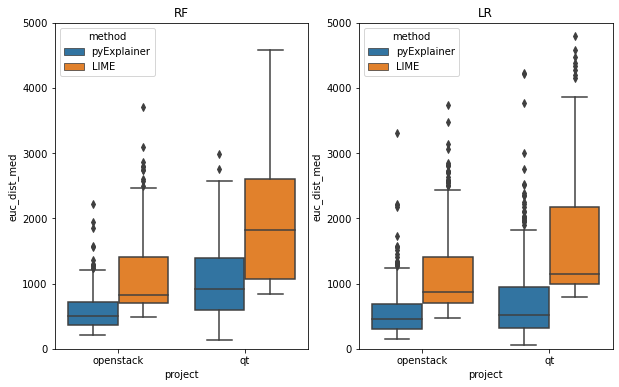

euc_dist_med                            \
                                          count         mean          std   
global_model project   method                                               
LR           openstack LIME               376.0  1132.167427   619.063720   
                       pyExplainer        376.0   558.381317   362.995597   
             qt        LIME               255.0  1711.110425  1178.955484   
                       pyExplainer        255.0   809.506167  1015.059387   
RF           openstack LIME               198.0  1126.515175   624.497655   
                       pyExplainer        198.0   592.534341   336.382084   
             qt        LIME                79.0  1981.191519   990.966337   
                       pyExplainer         79.0  1074.308665   658.831821   

                                                                          \
                                           min          25%          50%   
global_model project   method                                              
LR           openstack LIME         476.708280   702.140009   875.141469   
                       pyExplainer  148.657311   308.521417   457.295602   
             qt        LIME         790.051973   998.677483  1141.385858   
                       pyExplainer   55.357486   321.185126   513.627056   
RF           openstack LIME         483.787685   704.101313   825.157898   
                       pyExplainer  209.868295   362.603420   499.095996   
             qt        LIME         837.438216  1074.857259  1822.152824   
                       pyExplainer  142.328931   592.266300   918.419669   

                                                               \
                                            75%           max   
global_model project   method                                   
LR           openstack LIME         1409.733180   3730.730155   
                       pyExplainer   683.500513   3312.358240   
             qt        LIME         2176.112470  13054.448911   
                       pyExplainer   941.730553  12702.777783   
RF           openstack LIME         1409.115461   3704.200599   
                       pyExplainer   709.958265   2220.372483   
             qt        LIME         2602.846984   4576.189224   
                       pyExplainer  1386.723674   2981.257356   

                                   defective_generated_instance_ratio  \
                                                                count   
global_model project   method                                           
LR           openstack LIME                                     376.0   
                       pyExplainer                              376.0   
             qt        LIME                                     255.0   
                       pyExplainer                              255.0   
RF           openstack LIME                                     198.0   
                       pyExplainer                              198.0   
             qt        LIME                                      79.0   
                       pyExplainer                               79.0   

                                                                            \
                                        mean       std       min       25%   
global_model project   method                                                
LR           openstack LIME         0.597586  0.006338  0.576400  0.593400   
                       pyExplainer  0.687683  0.168490  0.168304  0.590557   
             qt        LIME         0.596206  0.006805  0.572800  0.591800   
                       pyExplainer  0.717320  0.169102  0.183929  0.639999   
RF           openstack LIME         0.165280  0.004570  0.154600  0.161850   
                       pyExplainer  0.560466  0.096553  0.211607  0.494551   
             qt        LIME         0.135856  0.004667  0.123000  0.133100   
                       pyExplainer  0.485140  0.06

In [26]:
show_rq1_eval_result()

# RQ2 evaluation

In [27]:
# def check_pyExp_prediction(proj_name,global_model_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name,global_model_name)
#     all_eval_result = pd.DataFrame()

#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         # this data can be used for both local and global model
#         py_exp_synthetic_data = py_exp['synthetic_data'].values
#         py_exp_local_model = py_exp['local_model']
#         py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
#         py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
#         py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        
#         tn, fp, fn, tp = confusion_matrix(py_exp_global_pred, py_exp_local_pred).ravel()
        
#         print('total prediction:',len(py_exp_global_pred))
#         print('TN:',tn,'FP:', fp,'FN:', fn,'TP:', tp)
# #         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

# #         pred_df = pd.DataFrame()
# #         pred_df['label'] = py_exp_global_pred
# #         pred_df['prob'] = py_exp_local_prob
# #         pred_df['pred'] = py_exp_local_pred
        
# #         true_pred_df = pred_df[pred_df['label']==True]
# #         print('total prediction:',len(pred_df))
# #         print('total global correct prediction:', len(true_pred_df))
# #         display(true_pred_df)
        
#         print('-'*100)
        
#         if i > 10:
#             break
# #         py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
# #         py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
# #         py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
# #         py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        
    

In [28]:
# check_pyExp_prediction('openstack')

In [29]:
# check_pyExp_prediction('qt')

In [30]:
def rq2_eval(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    all_eval_result = pd.DataFrame()

#     pyexp_pred_df = pd.DataFrame()
#     lime_pred_df = pd.DataFrame()
    
    pyexp_label, pyexp_prob = [],[]
    lime_label, lime_prob = [],[]
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(os.path.join(pyExp_dir,proj_name,global_model_name,'all_explainer_'+row_index+'.pkl'),'rb'))
#         exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
        py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
#         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_prob)
        
        pyexp_label.extend(list(py_exp_global_pred))
        pyexp_prob.extend(list(py_exp_local_prob))
        
        lime_label.extend(list(lime_exp_global_pred))
        lime_prob.extend(list(lime_exp_local_prob))
        
        
        py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
        py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
#         py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
#         py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        lime_auc = roc_auc_score(lime_exp_global_pred, lime_exp_local_prob)
        lime_f1 = f1_score(lime_exp_global_pred, lime_exp_local_pred)
#         lime_mcc = matthews_corrcoef(lime_exp_global_pred, lime_exp_local_pred)
#         lime_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                        py_exp_auc, py_exp_f1])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                           lime_auc, lime_f1])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
#         break

    pred_df = pd.DataFrame()
    
    all_tech = ['pyExplainer']*len(pyexp_label) + ['LIME']*len(lime_label)
    
    pred_df['technique'] = all_tech
    pred_df['label'] = pyexp_label+lime_label
    pred_df['prob'] = pyexp_prob+lime_prob
    pred_df['project'] = proj_name
    
    all_eval_result.columns = ['project', 'commit id', 'method', 'AUC', 'F1']

#     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ2_'+proj_name+'_'+global_model_name+'_global_vs_local_synt_pred.csv',index=False)
    pred_df.to_csv(result_dir+'RQ2_'+proj_name+'_'+global_model_name+'_probability_distribution.csv',index=False)
    print('finished RQ2 of',proj_name)

In [31]:
rq2_eval('openstack','RF')
rq2_eval('qt','RF')

finished RQ2 of openstack
finished RQ2 of qt


In [32]:
rq2_eval('openstack','lr')
rq2_eval('qt','lr')

finished RQ2 of openstack
finished RQ2 of qt


In [37]:
def show_rq2_eval_result():
    openstack_rf = pd.read_csv('./new_eval_result/RQ2_openstack_RF_global_vs_local_synt_pred.csv')
    qt_rf = pd.read_csv('./new_eval_result/RQ2_qt_RF_global_vs_local_synt_pred.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./new_eval_result/RQ2_openstack_LR_global_vs_local_synt_pred.csv')
    qt_lr = pd.read_csv('./new_eval_result/RQ2_qt_LR_global_vs_local_synt_pred.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

    fig, axs = plt.subplots(2,2, figsize=(10,10))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')
    
    axs[0,0].set_ylim([0, 1])
    axs[0,1].set_ylim([0, 1]) 
    axs[1,0].set_ylim([0, 1])
    axs[1,1].set_ylim([0, 1])

    sns.boxplot(data=result_rf, x='project', y='AUC', hue='method', ax=axs[0,0])
    sns.boxplot(data=result_rf, x='project', y='F1', hue='method', ax=axs[1,0])
    sns.boxplot(data=result_lr, x='project', y='AUC', hue='method', ax=axs[0,1])
    sns.boxplot(data=result_lr, x='project', y='F1', hue='method', ax=axs[1,1])


    plt.show()

    pd.set_option("max_columns", 40)
    display(all_result.groupby(['global_model', 'project','method']).describe())
    
#     result_rf.to_csv('./eval_result/RQ2_RF_prediction.csv',index=False)
#     result_lr.to_csv('./eval_result/RQ2_LR_prediction.csv',index=False)
#     all_result.to_csv('./eval_result/RQ2_prediction.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ2_prediction.png')
#     print('openstack result')
#     display(openstack_result_df.groupby('method').describe())
#     print('qt result')
#     display(qt_result_df.groupby('method').describe())

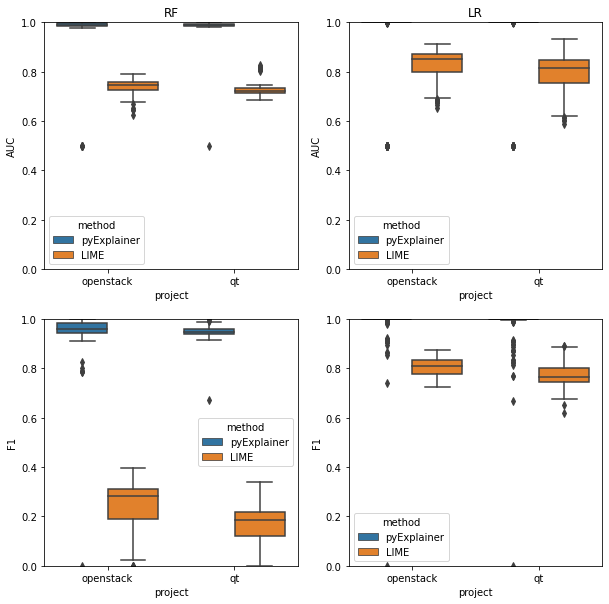

AUC                                \
                                    count      mean       std       min   
global_model project   method                                             
LR           openstack LIME         376.0  0.829102  0.055547  0.654471   
                       pyExplainer  376.0  0.965353  0.127003  0.500000   
             qt        LIME         255.0  0.799265  0.073640  0.587230   
                       pyExplainer  255.0  0.958771  0.137705  0.500000   
RF           openstack LIME         198.0  0.739778  0.028582  0.622698   
                       pyExplainer  198.0  0.973504  0.091100  0.500000   
             qt        LIME          79.0  0.727560  0.032064  0.684481   
                       pyExplainer   79.0  0.983411  0.055340  0.500000   

                                                                            \
                                         25%       50%       75%       max   
global_model project   method                                                
LR           openstack LIME         0.800182  0.849468  0.871452  0.913027   
                       pyExplainer  0.999999  1.000000  1.000000  1.000000   
             qt        LIME         0.754966  0.813798  0.846027  0.930847   
                       pyExplainer  0.999898  1.000000  1.000000  1.000000   
RF           openstack LIME         0.725468  0.747063  0.757772  0.792135   
                       pyExplainer  0.985086  0.988425  0.997700  1.000000   
             qt        LIME         0.711698  0.720274  0.731871  0.826997   
                       pyExplainer  0.985922  0.988490  0.992044  0.999988   

                                       F1                                \
                                    count      mean       std       min   
global_model project   method                                             
LR           openstack LIME         376.0  0.804673  0.031311  0.724138   
                       pyExplainer  376.0  0.989243  0.057882  0.000000   
             qt        LIME         255.0  0.776004  0.045181  0.620263   
                       pyExplainer  255.0  0.983292  0.075777  0.000000   
RF           openstack LIME         198.0  0.247077  0.089213  0.000000   
                       pyExplainer  198.0  0.950775  0.076806  0.000000   
             qt        LIME          79.0  0.164388  0.086351  0.000000   
                       pyExplainer   79.0  0.946981  0.037185  0.669439   

                                                                            
                                         25%       50%       75%       max  
global_model project   method                                               
LR           openstack LIME         0.776931  0.809816  0.830992  0.872978  
                       pyExplainer  0.999431  1.000000  1.000000  1.000000  
             qt        LIME         0.745791  0.765466  0.802436  0.887651  
                       pyExplainer  0.997761  1.000000  1.000000  1.000000  
RF           openstack LIME         0.189667  0.282794  0.311790  0.396056  
                       pyExplainer  0.941236  0.956598  0.982718  1.000000  
             qt        LIME         0.121791  0.186940  0.218175  0.337637  
                       pyExplainer  0.937660  0.947083  0.957854  0.999233

In [38]:
show_rq2_eval_result()

In [35]:
def show_rq2_prob_distribution():
    
    d = {True: 'DEFECT', False: 'CLEAN'}


    openstack_rf = pd.read_csv('./new_eval_result/RQ2_openstack_RF_probability_distribution.csv')
    qt_rf = pd.read_csv('./new_eval_result/RQ2_qt_RF_probability_distribution.csv')
    
    mask = openstack_rf.applymap(type) != bool
    openstack_rf = openstack_rf.where(mask, openstack_rf.replace(d))
    qt_rf = qt_rf.where(mask, qt_rf.replace(d))
    
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./new_eval_result/RQ2_openstack_LR_probability_distribution.csv')
    qt_lr = pd.read_csv('./new_eval_result/RQ2_qt_LR_probability_distribution.csv')
    
    openstack_lr = openstack_lr.where(mask, openstack_lr.replace(d))
    qt_lr = qt_lr.where(mask, qt_lr.replace(d))
    
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

#     display(all_result.head())
    fig, axs = plt.subplots(2,2, figsize=(10,10))

#     axs[0,0].set_title('RF')
#     axs[0,1].set_title('LR')
    
    axs[0,0].set_ylim([0, 1])
    axs[0,1].set_ylim([0, 1]) 
    axs[1,0].set_ylim([0, 1])
    axs[1,1].set_ylim([0, 1])
    
    sns.boxplot(data=openstack_rf, x='technique', y='prob', hue='label' , ax=axs[0,0])
    sns.boxplot(data=qt_rf,  x='technique', y='prob', hue='label' , ax=axs[1,0])
    sns.boxplot(data=openstack_lr,  x='technique', y='prob', hue='label' , ax=axs[0,1])
    sns.boxplot(data=qt_lr,  x='technique', y='prob', hue='label' , ax=axs[1,1], palette=['darkorange','royalblue'])
    
    axs[0,0].axhline(0.5, ls='--')
    axs[0,1].axhline(0.5, ls='--')
    axs[1,0].axhline(0.5, ls='--')
    axs[1,1].axhline(0.5, ls='--')
    
    cols = ['Global model: RF', 'Global model: LR']
    rows = ['Openstack','Qt']

    plt.setp(axs.flat, xlabel='Technique', ylabel='Probability')

    pad = 5 # in points

    for ax, col in zip(axs[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    for ax, row in zip(axs[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
    
    plt.show()
    display(all_result.groupby(['global_model', 'project','technique', 'label']).describe())
    
#     result_rf.to_csv('./eval_result/RQ2_RF_prediction_prob.csv',index=False)
#     result_lr.to_csv('./eval_result/RQ2_LR_prediction_prob.csv',index=False)
#     all_result.to_csv('./eval_result/RQ2_prediction_prob.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ2_prediction_prob.png')

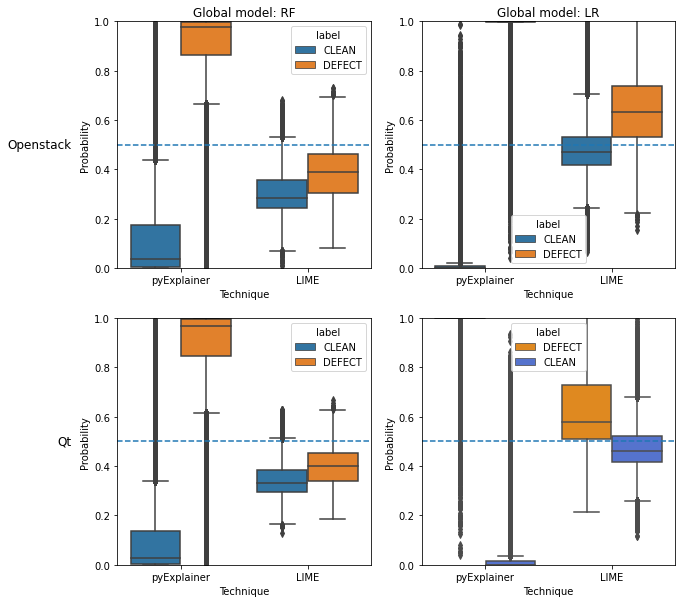

prob                      \
                                               count      mean       std   
global_model project   technique   label                                   
LR           openstack LIME        CLEAN    756538.0  0.479466  0.097678   
                                   DEFECT  1123462.0  0.642514  0.139432   
                       pyExplainer CLEAN    252495.0  0.052423  0.167843   
                                   DEFECT   563837.0  0.976524  0.065720   
             qt        LIME        CLEAN    514837.0  0.472216  0.096927   
                                   DEFECT   760163.0  0.613261  0.140138   
                       pyExplainer CLEAN    156239.0  0.072740  0.193846   
                                   DEFECT   402897.0  0.971792  0.081122   
RF           openstack LIME        CLEAN    826373.0  0.301605  0.085015   
                                   DEFECT   163627.0  0.389292  0.102954   
                       pyExplainer CLEAN    191279.0  0.128727  0.189382   
                                   DEFECT   242013.0  0.898262  0.159210   
             qt        LIME        CLEAN    341337.0  0.339123  0.062852   
                                   DEFECT    53663.0  0.399343  0.073789   
                       pyExplainer CLEAN     89581.0  0.109326  0.169970   
                                   DEFECT    84094.0  0.883541  0.175177   

                                                                       \
                                                    min           25%   
global_model project   technique   label                                
LR           openstack LIME        CLEAN   6.696869e-02  4.171309e-01   
                                   DEFECT  1.541047e-01  5.312962e-01   
                       pyExplainer CLEAN   3.828225e-67  3.349641e-08   
                                   DEFECT  4.144968e-02  9.986772e-01   
             qt        LIME        CLEAN   1.166307e-01  4.156490e-01   
                                   DEFECT  2.148441e-01  5.075561e-01   
                       pyExplainer CLEAN   2.628485e-64  1.985943e-08   
                                   DEFECT  4.096343e-02  9.990045e-01   
RF           openstack LIME        CLEAN   9.838514e-03  2.425580e-01   
                                   DEFECT  8.360751e-02  3.056182e-01   
                       pyExplainer CLEAN   1.174479e-36  3.405597e-03   
                                   DEFECT  1.121524e-03  8.643876e-01   
             qt        LIME        CLEAN   1.267091e-01  2.939760e-01   
                                   DEFECT  1.854316e-01  3.377640e-01   
                       pyExplainer CLEAN   1.306584e-13  4.326047e-03   
                                   DEFECT  4.739919e-03  8.442773e-01   

                                                                         
                                                50%       75%       max  
global_model project   technique   label                                 
LR           openstack LIME        CLEAN   0.471285  0.531705  1.084585  
                                   DEFECT  0.631915  0.738353  1.179022  
                       pyExplainer CLEAN   0.000051  0.007787  0.989075  
                                   DEFECT  0.999994  1.000000  1.000000  
             qt        LIME        CLEAN   0.459918  0.520321  0.992963  
                                   DEFECT  0.579007  0.727288  1.103117  
                       pyExplainer CLEAN   0.000069  0.013821  0.934690  
                                   DEFECT  0.999992  1.000000  1.000000  
RF           openstack LIME        CLEAN   0.282745  0.358711  0.680463  
                                   DEFECT  0.390604  0.461014  0.727913  
                       pyExplainer CLEAN   0.036523  0.176648  0.996641  
                                   DEFECT  0.977049  0.998391  1.000000  
             qt        LIME        CLEAN   0.329854  0.381940  0.627157  
                               

In [36]:
show_rq2_prob_distribution()

In [29]:
# def raname_files(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name = 'RF')
#     all_eval_result = pd.DataFrame()
#     x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')

#     for i in range(0,len(x_test)):
#         X_explain = x_test.iloc[[i]]

#         row_index = str(X_explain.index[0])
        
# #         old_filename = pyExp_dir+proj_name+'_all_explainer_'+row_index+'.pkl'
#         new_filename = pyExp_dir+proj_name+'_RF_all_explainer_'+row_index+'.pkl'
#         exp_obj = pickle.load(open(new_filename,'rb'))
        
#         # new filename: pyExp_dir+proj_name+'_RF_all_explainer_'+row_index+'.pkl'
# #         print(exp_obj.keys())
        
# #         pickle_file = pickle.load(open(pyExp_dir+proj_name+'_LR_all_explainer_'+row_index+'.pkl','rb'))
# #         os.rename(old_filename, new_filename)
        
#         break

#     print('finished')

# RQ3 evaluation

In [278]:
def eval_rule(rule, x_df):
    var_in_rule = list(set(re.findall('[a-zA-Z]+', rule)))
    
    rule = re.sub(r'\b=\b','==',rule)
    if 'or' in var_in_rule:
        var_in_rule.remove('or')
        
    rule = rule.replace('&','and')
    
    eval_result_list = []
    
#     print(rule)

    for i in range(0,len(x_df)):
        x = x_df.iloc[[i]]
        col = x.columns
        var_dict = {}

        for var in var_in_rule:
            var_dict[var] = float(x[var])

        eval_result = eval(rule,var_dict)
        eval_result_list.append(eval_result)
        
#         print(eval_result)
#         break
        
    return eval_result_list


def summarize_rule_eval_result(rule_str, x_df):
#     print('Rulefit')
    all_eval_result = eval_rule(rule_str, x_df)
    all_eval_result = np.array(all_eval_result).astype(bool)
    
#     result_df = pd.DataFrame()
#     result_df['ground_truth'] = ground_truth
#     result_df['rule_result'] = all_eval_result
#     result_df = result_df[result_df['rule_result']==True] # get commit that matches counter rule
    
#     print('py_exp_result_df')
#     display(py_exp_result_df[py_exp_result_df['ground_truth']==False])
#     print(len(py_exp_result_df))
    # find ratio of clean commit
#     satisfy_rule_ratio = 100*(len(result_df[result_df['ground_truth']==False])/len(result_df)) if len(result_df) > 0 else 0

    return all_eval_result

'''
    input:
        local_model: local model of RuleFit
        X_explain: an instance to be explained
        
    return:
        g2_guide, g4_guide (string)
        more info of g2/g4 guidance refers to SQAPlanner paper
'''

def get_g2_g4_guidance(local_model, X_explain):
    rules = local_model.get_rules()
    rules = rules[(rules['type']=='rule') & (rules['coef'] < 0) & (rules['importance'] > 0)]
    rules_list = list(rules['rule'])
    
    rule_eval_result = []

    for r in rules_list:
        py_exp_pred = eval_rule(r, X_explain)[0]
        rule_eval_result.append(py_exp_pred)
        
    rules['is_satisfy_instance'] = rule_eval_result

    dup_feature_in_rule = [] # true or false...
    
    # find which suggestion has duplicate variable...
    for r in rules_list:
        var_in_rule = re.findall('[a-zA-Z]+', r)
        var_count = Counter(var_in_rule)
        max_count = max(list(var_count.values()))
        
        if max_count > 1:
            dup_feature_in_rule.append(True)
        else:
            dup_feature_in_rule.append(False)
           
    if False not in set(dup_feature_in_rule):
        rules = rules.head(5)

    else:
        rules['contain_dup_var'] = dup_feature_in_rule    
        rules = rules[rules['contain_dup_var']==False]
        
    g2_guide_df = rules[rules['is_satisfy_instance']==True]
    g4_guide_df = rules[rules['is_satisfy_instance']==False]

    g2_guide_df = g2_guide_df.sort_values(by='coef', ascending=True)
    g4_guide_df = g4_guide_df.sort_values(by='coef', ascending=True)

    g2_guide = g2_guide_df.iloc[0]['rule']
    g4_guide = g4_guide_df.iloc[0]['rule']
    
    
    return g2_guide, g4_guide

In [43]:
def rq3_eval(proj_name, global_model_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    y_test_flip = [False if val else True for val in y_test]
    
    rq3_explanation_result = pd.DataFrame()
    
    pyexp_guidance_result_list = []
    lime_guidance_result_df = pd.DataFrame()
    
    for i in range(0,len(feature_df)):

        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        # load local models
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        # generate explanations                
        py_exp_the_best_defective_rule_str = get_g1_guidance(py_exp_local_model, X_explain)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        # check whether explanations apply to the instance to be explained
        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

        condition_list = py_exp_the_best_defective_rule_str.split('&')

        # for explanations
        for condition in condition_list:
            condition = condition.strip()

            py_exp_rule_eval = summarize_rule_eval_result(condition, x_test)

            rule_prec = precision_score(y_test, py_exp_rule_eval)
            rule_rec = recall_score(y_test, py_exp_rule_eval)

            py_exp_serie_test = pd.Series(data=[proj_name, row_index, 'pyExplainer',global_model_name, condition, rule_prec, rule_rec, py_exp_pred])
            rq3_explanation_result = rq3_explanation_result.append(py_exp_serie_test,ignore_index=True)

        # for guidance
        g2_guide, g4_guide = get_g2_g4_guidance(py_exp_local_model, X_explain)

        flip_guide_eval_result = eval_PyExplainer_guidance(proj_name, global_model_name,'PyExpFlip', row_index,
                                                           py_exp_the_best_defective_rule_str, x_test, y_test_flip, flip=True)
        g2_guide_eval_result = eval_PyExplainer_guidance(proj_name, global_model_name,'PyExpG2', row_index,
                                                           g2_guide, x_test, y_test_flip, flip=False)
        g4_guide_eval_result = eval_PyExplainer_guidance(proj_name, global_model_name,'PyExpG4', row_index,
                                                           g4_guide, x_test, y_test_flip, flip=False)

        pyexp_guidance_result_list.append(flip_guide_eval_result)
        pyexp_guidance_result_list.append(g2_guide_eval_result)
        pyexp_guidance_result_list.append(g4_guide_eval_result)
        # PyExp END
        
       
        # LIME START
        lime_rule_eval = summarize_rule_eval_result(lime_the_best_defective_rule_str, x_test)

        rule_prec = precision_score(y_test, lime_rule_eval)
        rule_rec = recall_score(y_test, lime_rule_eval)

        lime_serie_test = pd.Series(data=[proj_name, row_index, 'LIME',global_model_name, lime_the_best_defective_rule_str, rule_prec, rule_rec, lime_pred])
        rq3_explanation_result = rq3_explanation_result.append(lime_serie_test,ignore_index=True)

        lime_guidance = flip_rule(lime_the_best_defective_rule_str)
        lime_guidance_eval = summarize_rule_eval_result(lime_guidance, x_test)
#             tn, fp, fn, tp = confusion_matrix(y_test, lime_rule_eval, labels=[1,0]).ravel()
#             tp_rate = tp/(tp+fn)
#             tn_rate = tn/(tn+fp)

        guide_prec = precision_score(y_test_flip, lime_guidance_eval)
        guide_rec = recall_score(y_test_flip, lime_guidance_eval)

        lime_serie_test = pd.Series(data=[proj_name, row_index, 'LIME', global_model_name, lime_guidance, guide_prec, guide_rec])
        lime_guidance_result_df = lime_guidance_result_df.append(lime_serie_test, ignore_index=True)
            
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
        
        
    pyexp_guidance_result_df = pd.concat(pyexp_guidance_result_list)
    
    rq3_guidance_result = pd.concat([pyexp_guidance_result_df, lime_guidance_result_df])
    
    
    
    rq3_explanation_result.columns = ['project','commit_id','method','global_model','explanation','precision','recall', 'isSatisfy']
    rq3_guidance_result.columns = ['project','commit_id','method', 'global_model','guidance','precision','recall']

    rq3_explanation_result.to_csv(result_dir+'RQ3_'+proj_name+'_'+global_model_name+'_explanation_eval_split_rulefit_condition.csv',index=False)
    rq3_guidance_result.to_csv(result_dir+'RQ3_'+proj_name+'_'+global_model_name+'_guidance_eval_split_rulefit_condition.csv',index=False)

In [293]:
rq3_eval('openstack','RF')

recall: 0.8275550195960205
rule: la > 58.00
guidance: la <= 58.00 
3317


,la,nd,ns,ent,nrev,rtime,self,ndev,age,app,rrexp,asawr,rsawr,label
commit_id,,,,,,,,,,,,,,
5ce74eb5469b7f88f4448ccbc1afaa802a7cfdef,17,2,1,0.936667,7.0,17.869722,0,38.0,0.045706,1.0,1306.0,0.113107,0.247377,False
878ac164a391e761c72c5fdcd12f0caf48c7d359,49,9,3,0.718116,5.0,9.979109,0,116.0,13.035437,4.0,373.0,0.597853,0.296449,False
bbab55c4da531e4695a6e3e577aaa4975f0fce79,16,2,1,0.988699,6.0,81.107118,0,123.0,0.302407,7.0,2810.0,0.005334,0.389047,False
72d6f6d5f70c0d906ae2a2ac3c44f0b6eaaca8ef,10,1,1,0.000000,3.0,0.705880,0,29.0,5.140880,3.0,200.0,0.033573,0.285372,False
90620a27e0831345864f574256b30bac1ced5843,44,2,1,0.846439,5.0,19.982674,0,37.0,10.557407,3.0,2219.0,0.006932,0.279417,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60627ad73703c4f2258b21c8741edc22d8c8224d,20,2,1,0.286397,4.0,20.613206,0,52.0,0.320463,6.0,3298.0,0.000937,0.412930,False
209c09a76f5e90aaa2899804686e6a513703d887,2,1,1,0.000000,2.0,20.872523,1,0.0,0.000000,0.0,0.0,0.000000,0.000000,False
aaf5762be5d37cac022dc321b6400b9743a25303,4,2,1,0.413817,2.0,18.489861,0,49.0,26.872975,4.0,2299.0,0.004550,0.352067,False


In [294]:
2745/3317

0.8275550195960205

In [241]:
start = time.time()
print('openstack')
rq3_eval('openstack','RF')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
rq3_eval('qt','RF')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack
finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits
finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits
finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits
finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits
finished 34 from 198 commits
finished 35 from 198 commits
finished 36 from 198 commits
finished 37 from 198 commits
finished 38 from 198 commits
finished 39 from 198 commits
finished 40 from 198 commits
finished 41 from 198 commits
finished 42 from 198 commits
finished 43 from 198 commits
finished 44 from 198 commits
finished 45 from 198 commits
finished 46 from 198 commits
finished 47 from 198 commits
finished 48 fr

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 58 from 198 commits
finished 59 from 198 commits
finished 60 from 198 commits
finished 61 from 198 commits
finished 62 from 198 commits
finished 63 from 198 commits
finished 64 from 198 commits
finished 65 from 198 commits
finished 66 from 198 commits
finished 67 from 198 commits
finished 68 from 198 commits
finished 69 from 198 commits
finished 70 from 198 commits
finished 71 from 198 commits
finished 72 from 198 commits
finished 73 from 198 commits
finished 74 from 198 commits
finished 75 from 198 commits
finished 76 from 198 commits
finished 77 from 198 commits
finished 78 from 198 commits
finished 79 from 198 commits
finished 80 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 81 from 198 commits
finished 82 from 198 commits
finished 83 from 198 commits
finished 84 from 198 commits
finished 85 from 198 commits
finished 86 from 198 commits
finished 87 from 198 commits
finished 88 from 198 commits
finished 89 from 198 commits
finished 90 from 198 commits
finished 91 from 198 commits
finished 92 from 198 commits
finished 93 from 198 commits
finished 94 from 198 commits
finished 95 from 198 commits
finished 96 from 198 commits
finished 97 from 198 commits
finished 98 from 198 commits
finished 99 from 198 commits
finished 100 from 198 commits
finished 101 from 198 commits
finished 102 from 198 commits
finished 103 from 198 commits
finished 104 from 198 commits
finished 105 from 198 commits
finished 106 from 198 commits
finished 107 from 198 commits
finished 108 from 198 commits
finished 109 from 198 commits
finished 110 from 198 commits
finished 111 from 198 commits
finished 112 from 198 commits
finished 113 from 198 commits
finished 114 from 198 commits

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 138 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 139 from 198 commits
finished 140 from 198 commits
finished 141 from 198 commits
finished 142 from 198 commits
finished 143 from 198 commits
finished 144 from 198 commits
finished 145 from 198 commits
finished 146 from 198 commits
finished 147 from 198 commits
finished 148 from 198 commits
finished 149 from 198 commits
finished 150 from 198 commits
finished 151 from 198 commits
finished 152 from 198 commits
finished 153 from 198 commits
finished 154 from 198 commits
finished 155 from 198 commits
finished 156 from 198 commits
finished 157 from 198 commits
finished 158 from 198 commits
finished 159 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 160 from 198 commits
finished 161 from 198 commits
finished 162 from 198 commits
finished 163 from 198 commits
finished 164 from 198 commits
finished 165 from 198 commits
finished 166 from 198 commits
finished 167 from 198 commits
finished 168 from 198 commits
finished 169 from 198 commits
finished 170 from 198 commits
finished 171 from 198 commits
finished 172 from 198 commits
finished 173 from 198 commits
finished 174 from 198 commits
finished 175 from 198 commits
finished 176 from 198 commits
finished 177 from 198 commits
finished 178 from 198 commits
finished 179 from 198 commits
finished 180 from 198 commits
finished 181 from 198 commits
finished 182 from 198 commits
finished 183 from 198 commits
finished 184 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 185 from 198 commits
finished 186 from 198 commits
finished 187 from 198 commits
finished 188 from 198 commits
finished 189 from 198 commits
finished 190 from 198 commits
finished 191 from 198 commits
finished 192 from 198 commits
finished 193 from 198 commits
finished 194 from 198 commits
finished 195 from 198 commits
finished 196 from 198 commits
finished 197 from 198 commits
finished 198 from 198 commits
finished in 988.4625747203827 secs
qt
finished 1 from 79 commits
finished 2 from 79 commits
finished 3 from 79 commits
finished 4 from 79 commits
finished 5 from 79 commits
finished 6 from 79 commits
finished 7 from 79 commits
finished 8 from 79 commits
finished 9 from 79 commits
finished 10 from 79 commits
finished 11 from 79 commits
finished 12 from 79 commits
finished 13 from 79 commits
finished 14 from 79 commits
finished 15 from 79 commits
finished 16 from 79 commits
finished 17 from 79 commits
finished 18 from 79 commits
finished 19 from 79 commits
finished 20 from 79

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 26 from 79 commits
finished 27 from 79 commits
finished 28 from 79 commits
finished 29 from 79 commits
finished 30 from 79 commits
finished 31 from 79 commits
finished 32 from 79 commits
finished 33 from 79 commits
finished 34 from 79 commits
finished 35 from 79 commits
finished 36 from 79 commits
finished 37 from 79 commits
finished 38 from 79 commits
finished 39 from 79 commits
finished 40 from 79 commits
finished 41 from 79 commits
finished 42 from 79 commits
finished 43 from 79 commits
finished 44 from 79 commits
finished 45 from 79 commits
finished 46 from 79 commits
finished 47 from 79 commits
finished 48 from 79 commits
finished 49 from 79 commits
finished 50 from 79 commits
finished 51 from 79 commits
finished 52 from 79 commits
finished 53 from 79 commits
finished 54 from 79 commits
finished 55 from 79 commits
finished 56 from 79 commits
finished 57 from 79 commits
finished 58 from 79 commits
finished 59 from 79 commits
finished 60 from 79 commits
finished 61 from 79 

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 64 from 79 commits
finished 65 from 79 commits
finished 66 from 79 commits
finished 67 from 79 commits
finished 68 from 79 commits
finished 69 from 79 commits
finished 70 from 79 commits
finished 71 from 79 commits
finished 72 from 79 commits
finished 73 from 79 commits
finished 74 from 79 commits
finished 75 from 79 commits
finished 76 from 79 commits
finished 77 from 79 commits
finished 78 from 79 commits
finished 79 from 79 commits
finished in 640.3471386432648 secs


In [242]:
start = time.time()
print('openstack')
rq3_eval('openstack','LR')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
rq3_eval('qt','LR')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 1 from 376 commits
finished 2 from 376 commits
finished 3 from 376 commits
finished 4 from 376 commits
finished 5 from 376 commits
finished 6 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 7 from 376 commits
finished 8 from 376 commits
finished 9 from 376 commits
finished 10 from 376 commits
finished 11 from 376 commits
finished 12 from 376 commits
finished 13 from 376 commits
finished 14 from 376 commits
finished 15 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 16 from 376 commits
finished 17 from 376 commits
finished 18 from 376 commits
finished 19 from 376 commits
finished 20 from 376 commits
finished 21 from 376 commits
finished 22 from 376 commits
finished 23 from 376 commits
finished 24 from 376 commits
finished 25 from 376 commits
finished 26 from 376 commits
finished 27 from 376 commits
finished 28 from 376 commits
finished 29 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 30 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 31 from 376 commits
finished 32 from 376 commits
finished 33 from 376 commits
finished 34 from 376 commits
finished 35 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 36 from 376 commits
finished 37 from 376 commits
finished 38 from 376 commits
finished 39 from 376 commits
finished 40 from 376 commits
finished 41 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 42 from 376 commits
finished 43 from 376 commits
finished 44 from 376 commits
finished 45 from 376 commits
finished 46 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 47 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 48 from 376 commits
finished 49 from 376 commits
finished 50 from 376 commits
finished 51 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 52 from 376 commits
finished 53 from 376 commits
finished 54 from 376 commits
finished 55 from 376 commits
finished 56 from 376 commits
finished 57 from 376 commits
finished 58 from 376 commits
finished 59 from 376 commits
finished 60 from 376 commits
finished 61 from 376 commits
finished 62 from 376 commits
finished 63 from 376 commits
finished 64 from 376 commits
finished 65 from 376 commits
finished 66 from 376 commits
finished 67 from 376 commits
finished 68 from 376 commits
finished 69 from 376 commits
finished 70 from 376 commits
finished 71 from 376 commits
finished 72 from 376 commits
finished 73 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 74 from 376 commits
finished 75 from 376 commits
finished 76 from 376 commits
finished 77 from 376 commits
finished 78 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 79 from 376 commits
finished 80 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 81 from 376 commits
finished 82 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 83 from 376 commits
finished 84 from 376 commits
finished 85 from 376 commits
finished 86 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 87 from 376 commits
finished 88 from 376 commits
finished 89 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 90 from 376 commits
finished 91 from 376 commits
finished 92 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 93 from 376 commits
finished 94 from 376 commits
finished 95 from 376 commits
finished 96 from 376 commits
finished 97 from 376 commits
finished 98 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 99 from 376 commits
finished 100 from 376 commits
finished 101 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 102 from 376 commits
finished 103 from 376 commits
finished 104 from 376 commits
finished 105 from 376 commits
finished 106 from 376 commits
finished 107 from 376 commits
finished 108 from 376 commits
finished 109 from 376 commits
finished 110 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 111 from 376 commits
finished 112 from 376 commits
finished 113 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 114 from 376 commits
finished 115 from 376 commits
finished 116 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 117 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 118 from 376 commits
finished 119 from 376 commits
finished 120 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 121 from 376 commits
finished 122 from 376 commits
finished 123 from 376 commits
finished 124 from 376 commits
finished 125 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 126 from 376 commits
finished 127 from 376 commits
finished 128 from 376 commits
finished 129 from 376 commits
finished 130 from 376 commits
finished 131 from 376 commits
finished 132 from 376 commits
finished 133 from 376 commits
finished 134 from 376 commits
finished 135 from 376 commits
finished 136 from 376 commits
finished 137 from 376 commits
finished 138 from 376 commits
finished 139 from 376 commits
finished 140 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 141 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: 

In [279]:
'''
    X_explain: series
    global_model: global model of sklearn
    guidance: guidance of PyExplainer and LIME (single condition)
'''
def get_new_prob(X_explain, global_model, guidance, change_ratio):
    
    copy_x = X_explain.copy()
    
    prob_original = global_model.predict_proba(copy_x.values.reshape(1, -1))[:,1]
    
#     print('before replace')
#     print(copy_x)
    
#     print('suggestion:',guidance)
    
#     guidance_list = guidance.split('&')
    
    guidance = guidance.strip()

    tmp = guidance.split()
    var = tmp[0]
    logic = tmp[1]
    value = float(tmp[2])

    if value < 0:
        value = 0

#     print(value)
    if '<' in logic:
        copy_x[var] = value*(1-change_ratio)
    elif '>' in logic:
        copy_x[var] = value*(1+change_ratio)

#     print('after replace')
#     print(copy_x)
    
    prob_revised = global_model.predict_proba(copy_x.values.reshape(1, -1))[:,1]

    return float(prob_original), float(prob_revised)

def get_g1_guidance(local_model, X_explain):
    rules = local_model.get_rules()
    rules = rules[(rules['type']=='rule') & (rules['coef'] > 0) & (rules['importance'] > 0)]
    rules_list = list(rules['rule'])
    
    rule_eval_result = []
    
    dup_feature_in_rule = [] # true or false...
    
    for r in rules_list:
        py_exp_pred = eval_rule(r, X_explain)[0]
        rule_eval_result.append(py_exp_pred)

        var_in_rule = re.findall('[a-zA-Z]+', r)
        var_count = Counter(var_in_rule)
        max_count = max(list(var_count.values()))
        
        if max_count > 1:
            dup_feature_in_rule.append(True)
        else:
            dup_feature_in_rule.append(False)
          
    rules['is_satisfy_instance'] = rule_eval_result
    
    if False not in set(dup_feature_in_rule):
        rules = rules.head(5)
        
    else:
        rules['contain_dup_var'] = dup_feature_in_rule
        rules = rules[rules['contain_dup_var']==False]
        
    
    
    g1_guide_df = rules[rules['is_satisfy_instance']==True]

    g1_guide_df = g1_guide_df.sort_values(by='coef', ascending=False)
    
    g1_guide = g1_guide_df.iloc[0]['rule']
    
    return g1_guide

In [332]:
def change_val_of_commit(X_explain, guidance, change_ratio=0.4):

    guidance = guidance.strip()

    tmp = guidance.split()
    var = tmp[0]
    logic = tmp[1]
    value = float(tmp[2])

#     if value < 0:
#         value = 0

#     print(value)
    if '<' in logic and X_explain[var] > value:
        X_explain[var] = value*(1-change_ratio)
    elif '>' in logic and X_explain[var] < value:
        X_explain[var] = value*(1+change_ratio)
    elif '==' in logic:
        X_explain[var] = value

#     print('after replace')
#     print(copy_x)
    
    return X_explain

In [333]:
# for RQ4

def rq4_eval(proj_name, global_model_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)

#     display(feature_df.head())
    
    rq4_result_df = pd.DataFrame()
    total_row = len(feature_df)
    c = 0
    
    for row_index, row in feature_df.iterrows():
        row_df = pd.DataFrame([row])

        original_row = row.copy()
        original_prob = float(global_model.predict_proba(original_row.values.reshape(1, -1))[:,1])
    #         print(row_index)
    #         display(row)
    #         display(row_df)
    #         print(type(row))

    # for newly trained local model
        exp_obj = pickle.load(open(os.path.join(pyExp_dir,proj_name,global_model_name,'all_explainer_'+row_index+'.pkl'),'rb'))
#         exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        # load local models
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']



        # generate explanations                
        py_exp_the_best_defective_rule_str = get_g1_guidance(py_exp_local_model, row_df)

        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        g2_guide, g4_guide = get_g2_g4_guidance(py_exp_local_model, row_df)

#         print(py_exp_the_best_defective_rule_str)
        
        pyexp_row = row.copy()
        condition_list = []
        for g in py_exp_the_best_defective_rule_str.split('&'):
            g_flip = flip_rule(g)
            condition_list.append(g_flip)
#             print(g_flip)
            pyexp_row = change_val_of_commit(pyexp_row, g_flip)
            
        pyexp_flip_guide = ' & '.join(condition_list)
        pyexp_flip_guide_prob = float(global_model.predict_proba(pyexp_row.values.reshape(1, -1))[:,1])

        g2_row = row.copy()
        for g in g2_guide.split('&'):
            g2_row = change_val_of_commit(g2_row, g)
            
        g2_prob = float(global_model.predict_proba(g2_row.values.reshape(1, -1))[:,1])

        g4_row = row.copy()
        for g in g4_guide.split('&'):
            g4_row = change_val_of_commit(g4_row, g)

        g4_prob = float(global_model.predict_proba(g4_row.values.reshape(1, -1))[:,1])

#         keep this as template of old version
#         for g in g4_guide.split('&'):
#             prob_original, prob_revised = get_new_prob(original_row, global_model, g, change_ratio = 0.5)
#             rq4_result_df = rq4_result_df.append(pd.Series([proj_name, row_index, 'PyExpG4', global_model_name, 
#                                                    g, prob_original, prob_revised]),
#                                                 ignore_index=True)
#     #         print(g)
#     #         print(prob_original, prob_revised)

        '''
            sometimes defective commit rule of LIME looks like this: x < metric < y, where x >= 0, y >= 0
            so the suggestion will be metric < x or metric > y
            in this case the suggestion should be metrics > y since the metric can increase to any value
            but cannot derease to less than 0.
        '''
        lime_guide = flip_rule(lime_the_best_defective_rule_str)
        lime_guide_list = lime_guide.split('or')

        if len(lime_guide_list) > 1:
            lime_guide = lime_guide_list[1]
    
#         print(lime_guide)
        lime_row = row.copy()
#         print(lime_row)
        lime_row = change_val_of_commit(lime_row, lime_guide)
#         print(lime_row)
        
        lime_prob = float(global_model.predict_proba(lime_row.values.reshape(1, -1))[:,1])
        
        rq4_result_df = rq4_result_df.append(pd.Series([proj_name, row_index, 'PyExpFlip', global_model_name, 
                                                   pyexp_flip_guide, original_prob, pyexp_flip_guide_prob]),
                                                ignore_index=True)
        
        rq4_result_df = rq4_result_df.append(pd.Series([proj_name, row_index, 'PyExpG2', global_model_name, 
                                                   g2_guide, original_prob, g2_prob]),
                                                ignore_index=True)
        
        rq4_result_df = rq4_result_df.append(pd.Series([proj_name, row_index, 'PyExpG4', global_model_name, 
                                                   g4_guide, original_prob, g4_prob]),
                                                ignore_index=True)
        
        rq4_result_df = rq4_result_df.append(pd.Series([proj_name, row_index, 'LimeFlip', global_model_name, 
                                                   lime_guide, original_prob, lime_prob]),
                                                ignore_index=True)
        
        
#         print(original_prob, pyexp_flip_guide_prob, g2_prob, g4_prob, lime_prob)
#         print(lime_guide)
#         print(row.copy)
#         print(lime_row)
#         break
#         prob_original, prob_revised = get_new_prob(original_row, global_model, lime_guide, 
#                                                    change_ratio = 0.5)
#         rq4_result_df = rq4_result_df.append(pd.Series([proj_name, row_index, 'LimeFlip', global_model_name, 
#                                                    lime_guide, prob_original, prob_revised]),
#                                                 ignore_index=True)
        
#         c = c+1
        
#         if c > 10:
#             break
#         print('finish {}/{} commits'.format(str(c),str(total_row)))
        
        

    rq4_result_df.columns = ['project','commit_id','method','global_model','guidance','prob_original','prob_revised']
    display(rq4_result_df)
    
    # _new for newly trained local model
    # remove this to use the old local model
    rq4_result_df.to_csv(result_dir+'RQ4_'+proj_name+'_'+global_model_name+'_guidance_eval_no_dup_original_rulefit_condition_new.csv',index=False)

#     print('finished')
    #         break

In [334]:
rq4_eval('openstack', 'RF')

,project,commit_id,method,global_model,guidance,prob_original,prob_revised
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,PyExpFlip,RF,nrev > 2.9450000524520874 & rtime <= 1.129999...,0.57,0.17
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,PyExpG2,RF,asawr <= 0.024999999441206455 & app > 1.305000...,0.57,0.57
2,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,PyExpG4,RF,rtime > 5.769999980926514 & age <= 20.65000057...,0.57,0.20
3,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LimeFlip,RF,la <= 58.00,0.57,0.23
4,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,PyExpFlip,RF,ent > 0.9449999928474426 & la > 1318.74499511...,0.58,0.55
...,...,...,...,...,...,...,...
787,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,LimeFlip,RF,la <= 58.00,0.54,0.14
788,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,PyExpFlip,RF,la <= 10.860000133514404 & rtime <= 3.8249999...,0.51,0.14
789,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,PyExpG2,RF,rtime > -1.5250000357627869 & la <= 80.4700012...,0.51,0.51
790,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,PyExpG4,RF,rtime <= 3.8249999284744263 & ndev > 23.779999...,0.51,0.35


In [335]:
rq4_eval('openstack', 'LR')

,project,commit_id,method,global_model,guidance,prob_original,prob_revised
0,openstack,71f2184c617123b90f8e911056f23e3346c7c592,PyExpFlip,LR,age > 7.8450000286102295 & app > 2.9450000524...,0.541549,0.313998
1,openstack,71f2184c617123b90f8e911056f23e3346c7c592,PyExpG2,LR,age > 2.1449999809265137 & rtime > -10.7849998...,0.541549,0.541549
2,openstack,71f2184c617123b90f8e911056f23e3346c7c592,PyExpG4,LR,nrev <= 1.0199999809265137 & rrexp <= 1238.5 &...,0.541549,0.422677
3,openstack,71f2184c617123b90f8e911056f23e3346c7c592,LimeFlip,LR,nrev <= 4.00,0.541549,0.470816
4,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,PyExpFlip,LR,age > 25.994999885559082 & nrev <= 5.38499999...,0.946528,0.488307
...,...,...,...,...,...,...,...
1499,openstack,3c9ed23f7939b1ace78b39b53fc4e89d759f6fa5,LimeFlip,LR,la <= 58.00,0.974976,0.908273
1500,openstack,0c6c57d70826b36db30795fa993cf677a4c2a6e4,PyExpFlip,LR,app > 2.5649999380111694 & rrexp <= 325.40000...,0.507774,0.323139
1501,openstack,0c6c57d70826b36db30795fa993cf677a4c2a6e4,PyExpG2,LR,rtime > -50.92499923706055 & age > -14.8099999...,0.507774,0.507774
1502,openstack,0c6c57d70826b36db30795fa993cf677a4c2a6e4,PyExpG4,LR,la <= 7.75 & rrexp <= 1185.6199951171875,0.507774,0.504187


In [336]:
rq4_eval('qt', 'RF')

,project,commit_id,method,global_model,guidance,prob_original,prob_revised
0,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,PyExpFlip,RF,la <= 54.05500030517578 & ent <= 0.4500000029...,0.77,0.48
1,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,PyExpG2,RF,la <= 307.63499450683594 & nrev > 3.6150000095...,0.77,0.77
2,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,PyExpG4,RF,la <= 54.05500030517578 & nrev > 4.78499984741...,0.77,0.42
3,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,LimeFlip,RF,rtime != 64,0.77,0.77
4,qt,602bd9873786ccadcb67da3036329f3122555cf8,PyExpFlip,RF,rtime <= -0.015000004321336746 & rsexp <= 956...,0.58,0.33
...,...,...,...,...,...,...,...
311,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,LimeFlip,RF,rtime != 6,0.80,0.80
312,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,PyExpFlip,RF,ent <= 0.004999999888241291 & nd > 8.98999977...,0.66,0.34
313,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,PyExpG2,RF,app > 2.8149999380111694 & asawr <= 0.09500000...,0.66,0.66
314,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,PyExpG4,RF,ent > 0.4099999964237213 & la <= 17.0999994277...,0.66,0.24


In [337]:
rq4_eval('qt', 'LR')

,project,commit_id,method,global_model,guidance,prob_original,prob_revised
0,qt,e443f6dc7df2e5a0bd2ab890c3b6094500f5b9ab,PyExpFlip,LR,nd > 2.59499990940094 & age > 28.135000228881...,0.708054,0.556224
1,qt,e443f6dc7df2e5a0bd2ab890c3b6094500f5b9ab,PyExpG2,LR,age <= 31.640000343322754 & asexp <= 560.92001...,0.708054,0.708054
2,qt,e443f6dc7df2e5a0bd2ab890c3b6094500f5b9ab,PyExpG4,LR,ndev <= 27.789999961853027 & age <= 28.1350002...,0.708054,0.597727
3,qt,e443f6dc7df2e5a0bd2ab890c3b6094500f5b9ab,LimeFlip,LR,la <= 31.00,0.708054,0.704559
4,qt,89de921c2f6928a691f6aaa2165b5c1739f156cd,PyExpFlip,LR,rsexp > 167.1999969482422,0.627095,0.608848
...,...,...,...,...,...,...,...
1015,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,LimeFlip,LR,la <= 31.00,0.609164,0.602163
1016,qt,337524714cad51934879d817564c5d58e6dbd0c0,PyExpFlip,LR,age > 33.5049991607666 & rsexp > 866.30499267...,0.675246,0.459873
1017,qt,337524714cad51934879d817564c5d58e6dbd0c0,PyExpG2,LR,ent <= 1.2899999618530273 & ndev <= 11.1849999...,0.675246,0.675246
1018,qt,337524714cad51934879d817564c5d58e6dbd0c0,PyExpG4,LR,age > 6.085000038146973 & hcmt <= 9.4699997901...,0.675246,0.512539


In [338]:
openstack_rf = pd.read_csv('./new_eval_result/RQ4_openstack_RF_guidance_eval_no_dup_original_rulefit_condition_new.csv')
qt_rf = pd.read_csv('./new_eval_result/RQ4_qt_RF_guidance_eval_no_dup_original_rulefit_condition_new.csv')
result_rf = pd.concat([openstack_rf, qt_rf])
result_rf['global_model'] = 'RF'

# result_rf.to_csv('./new_eval_result/RQ4_RF_guidance_eval_original_rulefit_condition.csv',index=False)

openstack_lr = pd.read_csv('./new_eval_result/RQ4_openstack_LR_guidance_eval_no_dup_original_rulefit_condition_new.csv')
qt_lr = pd.read_csv('./new_eval_result/RQ4_qt_LR_guidance_eval_no_dup_original_rulefit_condition_new.csv')
result_lr = pd.concat([openstack_lr, qt_lr])
result_lr['global_model'] = 'LR'

all_result = pd.concat([result_rf, result_lr])

all_result.to_csv('./new_eval_result/RQ4_guidance_eval_no_dup_original_rulefit_condition_new.csv', index=False)

In [339]:
# openstack_rf = pd.read_csv('./new_eval_result/RQ4_openstack_RF_guidance_eval_split_rulefit_condition.csv')
# qt_rf = pd.read_csv('./new_eval_result/RQ4_qt_RF_guidance_eval_split_rulefit_condition.csv')
# result_rf = pd.concat([openstack_rf, qt_rf])
# result_rf['global_model'] = 'RF'

# # result_rf.to_csv('./new_eval_result/RQ4_RF_guidance_eval_split_rulefit_condition.csv',index=False)

# openstack_lr = pd.read_csv('./new_eval_result/RQ4_openstack_LR_guidance_eval_split_rulefit_condition.csv')
# qt_lr = pd.read_csv('./new_eval_result/RQ4_qt_LR_guidance_eval_split_rulefit_condition.csv')
# result_lr = pd.concat([openstack_lr, qt_lr])
# result_lr['global_model'] = 'LR'

# all_result = pd.concat([result_rf, result_lr])

# all_result.to_csv('./new_eval_result/RQ4_guidance_eval_split_rulefit_condition.csv', index=False)

3632


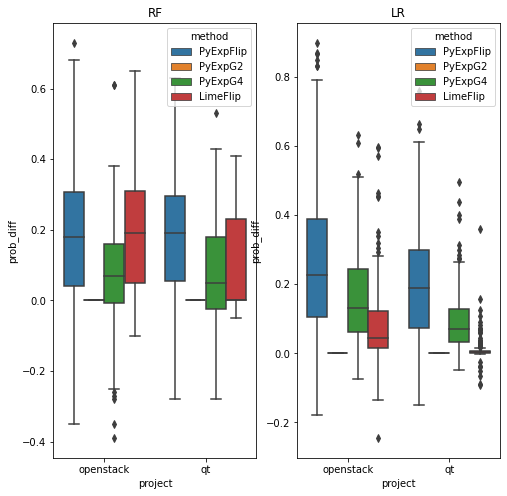

count      mean       std       min  \
project   method    global_model                                        
openstack LimeFlip  LR            376.0  0.078738  0.098331 -0.245294   
                    RF            198.0  0.196111  0.174279 -0.100000   
          PyExpFlip LR            376.0  0.260765  0.207199 -0.178194   
                    RF            198.0  0.166364  0.205325 -0.350000   
          PyExpG2   LR            376.0  0.000000  0.000000  0.000000   
                    RF            198.0  0.000000  0.000000  0.000000   
          PyExpG4   LR            376.0  0.161408  0.134509 -0.074930   
                    RF            198.0  0.076768  0.146505 -0.390000   
qt        LimeFlip  LR            255.0  0.008494  0.031644 -0.090525   
                    RF             79.0  0.108734  0.132948 -0.050000   
          PyExpFlip LR            255.0  0.204671  0.160440 -0.149285   
                    RF             79.0  0.174810  0.180760 -0.280000   
          PyExpG2   LR            255.0  0.000000  0.000000  0.000000   
                    RF             79.0  0.000000  0.000000  0.000000   
          PyExpG4   LR            255.0  0.091071  0.080976 -0.048743   
                    RF             79.0  0.073671  0.178341 -0.280000   

                                       25%       50%       75%       max  
project   method    global_model                                          
openstack LimeFlip  LR            0.013915  0.043796  0.123391  0.596619  
                    RF            0.050000  0.190000  0.310000  0.650000  
          PyExpFlip LR            0.104534  0.227801  0.388520  0.899127  
                    RF            0.040000  0.180000  0.307500  0.730000  
          PyExpG2   LR            0.000000  0.000000  0.000000  0.000000  
                    RF            0.000000  0.000000  0.000000  0.000000  
          PyExpG4   LR            0.060235  0.131105  0.243605  0.631241  
                    RF           -0.007500  0.070000  0.160000  0.610000  
qt        LimeFlip  LR            0.000528  0.002372  0.007027  0.359882  
                    RF            0.000000  0.000000  0.230000  0.410000  
          PyExpFlip LR            0.074024  0.187628  0.297868  0.758214  
                    RF            0.055000  0.190000  0.295000  0.630000  
          PyExpG2   LR            0.000000  0.000000  0.000000  0.000000  
                    RF            0.000000  0.000000  0.000000  0.000000  
          PyExpG4   LR            0.033330  0.070439  0.127013  0.496702  
                    RF           -0.025000  0.050000  0.180000  0.530000

In [340]:
def show_rq4_result():
    all_result = pd.read_csv('./new_eval_result/RQ4_guidance_eval_no_dup_original_rulefit_condition_new.csv')
    
#     all_guidance = list(all_result['guidance'])
# #     sample_guidance = all_guidance[:10]
# #     print(sample_guidance)
#     found_negative_val = []
    
#     for g in all_guidance:
#         total_found = len(re.findall('-\d+.\d+', g)) # count number of negative values in each guidance
#         found_negative_val.append(total_found)
        
#     all_result['bad_guidance'] = found_negative_val
#     all_result = all_result[all_result['bad_guidance']==0]
    
#     print(len(all_guidance))
    all_result['prob_diff'] = all_result['prob_original']-all_result['prob_revised']
    
    result_rf = all_result[all_result['global_model']=='RF']
    result_lr = all_result[all_result['global_model']=='LR']
    
    print(len(all_result))
#     display(all_result.head(40))

    fig, axs = plt.subplots(1,2, figsize=(8,8))

    axs[0].set_title('RF')
    axs[1].set_title('LR')

    # plt.ylim(0,100)
    sns.boxplot(data=result_rf, x='project', y='prob_diff', hue='method', ax=axs[0])
    sns.boxplot(data=result_lr, x='project', y='prob_diff', hue='method', ax=axs[1])
    
    plt.show()
    
    display(all_result.groupby(['project','method','global_model']).describe()['prob_diff'])
show_rq4_result()

In [341]:
def show_rq4_result():
    all_result = pd.read_csv('./new_eval_result/RQ4_guidance_eval_no_dup_original_rulefit_condition_new.csv')
    
#     all_guidance = list(all_result['guidance'])
#     found_negative_val = []
    
#     for g in all_guidance:
#         total_found = len(re.findall('-\d+.\d+', g)) # count number of negative values in each guidance
#         found_negative_val.append(total_found)
        
#     all_result['bad_guidance'] = found_negative_val
#     all_result = all_result[all_result['bad_guidance']==0]

    all_result['pred_original'] = np.round(all_result['prob_original']).astype(bool)
    all_result['pred_revised'] = np.round(all_result['prob_revised']).astype(bool)
    all_result['is_reverse_pred'] = (all_result['pred_original']==True) &  (all_result['pred_revised']==False) 
    
#     display(all_result)
    summary = all_result.groupby(['project','method','global_model']).sum()
    display(summary)
    
    display(100*summary['is_reverse_pred']/summary['pred_original'])
#     display(all_result.head(50))
    
show_rq4_result()

prob_original  prob_revised  pred_original  \
project   method    global_model                                               
openstack LimeFlip  LR               261.628040    232.022465            376   
                    RF               124.710000     85.880000            198   
          PyExpFlip LR               261.628040    163.580374            376   
                    RF               124.710000     91.770000            198   
          PyExpG2   LR               261.628040    261.628040            376   
                    RF               124.710000    124.710000            198   
          PyExpG4   LR               261.628040    200.938736            376   
                    RF               124.710000    109.510000            198   
qt        LimeFlip  LR               166.101089    163.935051            255   
                    RF                49.770000     41.180000             79   
          PyExpFlip LR               166.101089    113.910095            255   
                    RF                49.770000     35.960000             79   
          PyExpG2   LR               166.101089    166.101089            255   
                    RF                49.770000     49.770000             79   
          PyExpG4   LR               166.101089    142.877923            255   
                    RF                49.770000     43.950000             79   

                                  pred_revised  is_reverse_pred  
project   method    global_model                                 
openstack LimeFlip  LR                     278               98  
                    RF                      72              126  
          PyExpFlip LR                     117              259  
                    RF                      81              117  
          PyExpG2   LR                     376                0  
                    RF                     198                0  
          PyExpG4   LR                     195              181  
                    RF                     123               75  
qt        LimeFlip  LR                     242               13  
                    RF                      43               36  
          PyExpFlip LR                      81              174  
                    RF                      27               52  
          PyExpG2   LR                     255                0  
                    RF                      79                0  
          PyExpG4   LR                     179               76  
                    RF                      45               34

project    method     global_model
openstack  LimeFlip   LR              26.063830
                      RF              63.636364
           PyExpFlip  LR              68.882979
                      RF              59.090909
           PyExpG2    LR               0.000000
                      RF               0.000000
           PyExpG4    LR              48.138298
                      RF              37.878788
qt         LimeFlip   LR               5.098039
                      RF              45.569620
           PyExpFlip  LR              68.235294
                      RF              65.822785
           PyExpG2    LR               0.000000
                      RF               0.000000
           PyExpG4    LR              29.803922
                      RF              43.037975
dtype: float64

In [20]:
rq4_eval('openstack','RF')

,la,nd,ns,ent,nrev,rtime,self,ndev,age,app,rrexp,asawr,rsawr,pred,defective_prob,defect
commit_id,,,,,,,,,,,,,,,,
1e6973aee7137653c62dcef970b1e2527b50517d,258,2,1,0.826278,2.0,18.049560,0,1.0,5.242755,4.0,465.0,0.004262,0.082046,True,0.57,True
5d0ccceb20780fdd3adf519d3f8e6b80b1844407,190,7,1,0.839470,25.0,15.181620,0,164.0,0.833137,2.0,1931.0,0.122340,0.361879,True,0.58,True
de31210c05f464c4a79255de68b1a515d9b84ed3,121,2,1,0.758523,2.0,0.357431,0,11.0,4.983553,2.0,812.0,0.057416,0.873206,True,0.61,True
957533f685caf9ffc0d9cad569598455d59ade34,121,5,1,0.863629,7.0,19.054421,0,4.0,7.935347,5.0,1364.0,0.197917,0.911458,True,0.60,True
96677735f6d8f1f5b6380127956921f719aab799,525,2,1,0.707022,29.0,20.117373,0,7.0,4.144878,1.0,98.0,0.002381,0.104762,True,0.56,True


1e6973aee7137653c62dcef970b1e2527b50517d


la                     258
nd                       2
ns                       1
ent               0.826278
nrev                   2.0
rtime             18.04956
self                     0
ndev                   1.0
age               5.242755
app                    4.0
rrexp                465.0
asawr             0.004262
rsawr             0.082046
pred                  True
defective_prob        0.57
defect                True
Name: 1e6973aee7137653c62dcef970b1e2527b50517d, dtype: object

,la,nd,ns,ent,nrev,rtime,self,ndev,age,app,rrexp,asawr,rsawr,pred,defective_prob,defect
1e6973aee7137653c62dcef970b1e2527b50517d,258,2,1,0.826278,2.0,18.04956,0,1.0,5.242755,4.0,465.0,0.004262,0.082046,True,0.57,True


# Old code (may keep in case needed later)

In [ ]:
openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF_explanation_eval_split_rulefit_condition.csv')
qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF_explanation_eval_split_rulefit_condition.csv')
result_rf = pd.concat([openstack_rf, qt_rf])
result_rf['global_model'] = 'RF'

result_rf.to_csv('./eval_result/RQ3_RF_explanation_eval_split_rulefit_condition.csv',index=False)
openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR_explanation_eval_split_rulefit_condition.csv')
qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR_split_explanation_eval_split_rulefit_condition.csv')
result_lr = pd.concat([openstack_lr, qt_lr])
result_lr['global_model'] = 'LR'

all_result = pd.concat([result_rf, result_lr])

all_result.to_csv('./eval_result/RQ3_explanation_eval_split_rulefit_condition.csv', index=False)

In [ ]:
openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF_guidance_eval_split_rulefit_condition.csv')
qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF_guidance_eval_split_rulefit_condition.csv')
result_rf = pd.concat([openstack_rf, qt_rf])
result_rf['global_model'] = 'RF'

result_rf.to_csv('./eval_result/RQ3_RF_guidance_eval_split_rulefit_condition.csv',index=False)
openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR_guidance_eval_split_rulefit_condition.csv')
qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR_split_guidance_eval_split_rulefit_condition.csv')
result_lr = pd.concat([openstack_lr, qt_lr])
result_lr['global_model'] = 'LR'

all_result = pd.concat([result_rf, result_lr])

all_result.to_csv('./eval_result/RQ3_guidance_eval_split_rulefit_condition.csv', index=False)

In [34]:
def show_rq3_explanation_eval_result():

    openstack_rf = pd.read_csv('./new_eval_result/RQ3_openstack_RF_new.csv')
    qt_rf = pd.read_csv('./new_eval_result/RQ3_qt_RF_new.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./new_eval_result/RQ3_openstack_LR_new.csv')
    qt_lr = pd.read_csv('./new_eval_result/RQ3_qt_LR_new.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

#     display(all_result.head(10))
    
    my_pal = ['darkorange','blue']

    fig, axs = plt.subplots(2,2, figsize=(8,8))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')

    # plt.ylim(0,100)
    sns.boxplot(data=result_rf, x='project', y='explantion_precision', hue='method', ax=axs[0,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_rf, x='project', y='explantion_recall', hue='method', ax=axs[1,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_lr, x='project', y='explantion_precision', hue='method', ax=axs[0,1], palette=['royalblue','darkorange'])
    sns.boxplot(data=result_lr, x='project', y='explantion_recall', hue='method', ax=axs[1,1], palette=['royalblue','darkorange'])

    plt.show()
    
    display(all_result[['global_model', 'project','method', 'explantion_precision','explantion_recall']]
            .groupby(['global_model','project','method']).describe())
    
#     result_rf.to_csv('./new_eval_result/RQ3_explanation_RF.csv',index=False)
#     result_lr.to_csv('./new_eval_result/RQ3_explanation_LR.csv',index=False)
#     all_result.to_csv('./new_eval_result/RQ3_explanation.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ3.png')
    

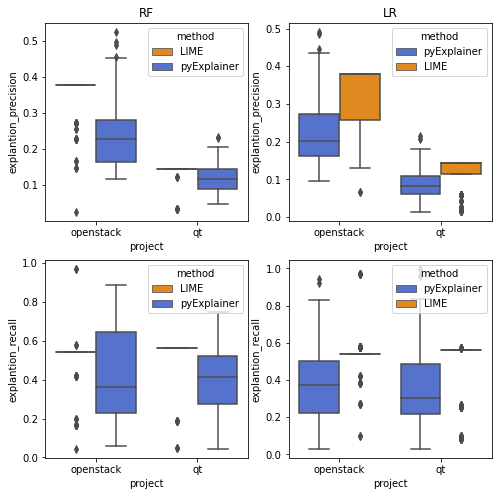

explantion_precision                      \
                                                  count      mean       std   
global_model project   method                                                 
LR           openstack LIME                       376.0  0.335419  0.075056   
                       pyExplainer                203.0  0.223915  0.081137   
             qt        LIME                       254.0  0.120941  0.042186   
                       pyExplainer                148.0  0.089164  0.037237   
RF           openstack LIME                       198.0  0.357511  0.057134   
                       pyExplainer                113.0  0.250254  0.097709   
             qt        LIME                        48.0  0.123950  0.041644   
                       pyExplainer                 43.0  0.121098  0.046245   

                                                                            \
                                         min       25%       50%       75%   
global_model project   method                                                
LR           openstack LIME         0.066259  0.256868  0.378936  0.378936   
                       pyExplainer  0.095949  0.161777  0.201790  0.273904   
             qt        LIME         0.015282  0.112635  0.143854  0.143854   
                       pyExplainer  0.014042  0.059482  0.082731  0.108330   
RF           openstack LIME         0.026630  0.378936  0.378936  0.378936   
                       pyExplainer  0.118156  0.165725  0.226885  0.281899   
             qt        LIME         0.032544  0.143854  0.143854  0.143854   
                       pyExplainer  0.047084  0.088905  0.118074  0.143709   

                                             explantion_recall            \
                                         max             count      mean   
global_model project   method                                              
LR           openstack LIME         0.378936             376.0  0.544768   
                       pyExplainer  0.491039             203.0  0.376085   
             qt        LIME         0.143854             254.0  0.485799   
                       pyExplainer  0.214912             148.0  0.351578   
RF           openstack LIME         0.378936             198.0  0.513400   
                       pyExplainer  0.525641             113.0  0.417340   
             qt        LIME         0.143854              48.0  0.467700   
                       pyExplainer  0.233333              43.0  0.406732   

                                                                            \
                                         std       min       25%       50%   
global_model project   method                                                
LR           openstack LIME         0.085677  0.100619  0.540248  0.540248   
                       pyExplainer  0.182666  0.029412  0.222910  0.369969   
             qt        LIME         0.154259  0.081933  0.563025  0.563025   
                       pyExplainer  0.190425  0.029412  0.215861  0.303571   
RF           openstack LIME         0.106922  0.044892  0.540248  0.540248   
                       pyExplainer  0.219388  0.058824  0.230650  0.363777   
             qt        LIME         0.179187  0.046218  0.563025  0.563025   
                       pyExplainer  0.184255  0.044118  0.277311  0.413866   

                                                        
                                         75%       max  
global_model project   method                           
LR           openstack LIME         0.540248  0.969040  
                       pyExplainer  0.499226  0.944272  
             qt        LIME         0.563025  0.569328  
                       pyExplainer  0.483718  0.995798  
RF           openstack LIME         0.540248  0.969040  
                       pyExplainer  0.645511  0.888545  
             qt        LIME         0.563025  0.563025  
                       pyExplainer  0.52

In [45]:
show_rq3_explanation_eval_result()

In [269]:
def show_rq4_split_guidance_eval_result():

    openstack_rf = pd.read_csv('./new_eval_result/RQ3_openstack_RF_guidance_eval_split_rulefit_condition.csv')
    qt_rf = pd.read_csv('./new_eval_result/RQ3_qt_RF_guidance_eval_split_rulefit_condition.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./new_eval_result/RQ3_openstack_LR_guidance_eval_split_rulefit_condition.csv')
    qt_lr = pd.read_csv('./new_eval_result/RQ3_qt_LR_guidance_eval_split_rulefit_condition.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

#     display(all_result.head(10))
    
#     my_pal = ['darkorange','blue']

    fig, axs = plt.subplots(2,2, figsize=(12,8))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')

    # plt.ylim(0,100)
    sns.boxplot(data=result_rf, x='project', y='precision', hue='method', ax=axs[0,0])
    sns.boxplot(data=result_rf, x='project', y='recall', hue='method', ax=axs[1,0])
    sns.boxplot(data=result_lr, x='project', y='precision', hue='method', ax=axs[0,1])
    sns.boxplot(data=result_lr, x='project', y='recall', hue='method', ax=axs[1,1])

    plt.show()
    
    display(all_result[['global_model', 'project','method', 'precision', 'recall']]
            .groupby(['global_model','project','method']).describe())
    
#     result_rf.to_csv('./new_eval_result/RQ3_explanation_RF.csv',index=False)
#     result_lr.to_csv('./new_eval_result/RQ3_explanation_LR.csv',index=False)
#     all_result.to_csv('./new_eval_result/RQ3_explanation.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ3.png')
    

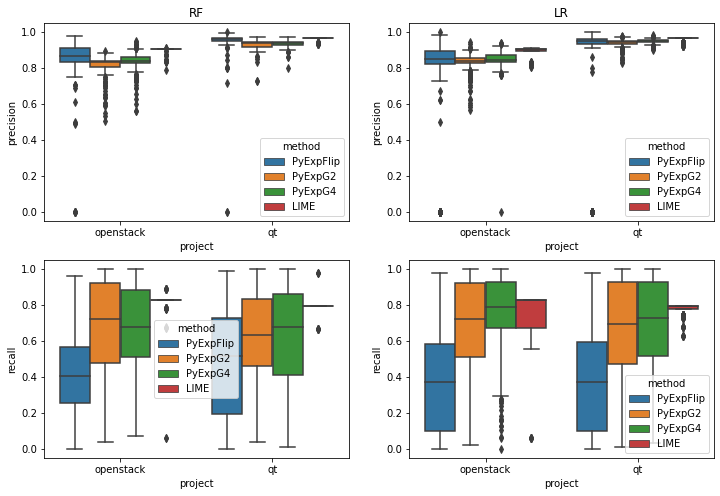

precision                                \
                                     count      mean       std       min   
global_model project   method                                              
LR           openstack LIME          376.0  0.895572  0.019231  0.805164   
                       PyExpFlip     490.0  0.739513  0.308665  0.000000   
                       PyExpG2       517.0  0.835213  0.042945  0.567568   
                       PyExpG4       563.0  0.850666  0.045732  0.000000   
             qt        LIME          254.0  0.960790  0.013299  0.923668   
                       PyExpFlip     342.0  0.820591  0.328760  0.000000   
                       PyExpG2       382.0  0.940625  0.019111  0.828836   
                       PyExpG4       418.0  0.947731  0.010551  0.899452   
RF           openstack LIME          198.0  0.896500  0.017441  0.785317   
                       PyExpFlip     309.0  0.845751  0.151591  0.000000   
                       PyExpG2       294.0  0.813419  0.056219  0.505882   
                       PyExpG4       291.0  0.834581  0.052596  0.561905   
             qt        LIME           48.0  0.959895  0.014524  0.930379   
                       PyExpFlip     110.0  0.932565  0.134302  0.000000   
                       PyExpG2       106.0  0.928931  0.036214  0.727273   
                       PyExpG4       115.0  0.934684  0.023960  0.798077   

                                                                          \
                                       25%       50%       75%       max   
global_model project   method                                              
LR           openstack LIME       0.891504  0.902367  0.902367  0.909910   
                       PyExpFlip  0.822680  0.848937  0.891504  1.000000   
                       PyExpG2    0.827801  0.836992  0.856792  0.944832   
                       PyExpG4    0.832589  0.842716  0.872960  0.938305   
             qt        LIME       0.965083  0.967571  0.967571  0.967571   
                       PyExpFlip  0.931437  0.949506  0.962329  1.000000   
                       PyExpG2    0.935418  0.942491  0.949489  0.975530   
                       PyExpG4    0.942491  0.947669  0.953139  0.983942   
RF           openstack LIME       0.902367  0.902367  0.902367  0.909910   
                       PyExpFlip  0.834281  0.864831  0.911408  0.979310   
                       PyExpG2    0.805164  0.831992  0.838099  0.896046   
                       PyExpG4    0.826498  0.836992  0.860456  0.947073   
             qt        LIME       0.967571  0.967571  0.967571  0.967571   
                       PyExpFlip  0.948537  0.961164  0.968528  1.000000   
                       PyExpG2    0.918220  0.939717  0.946056  0.972369   
                       PyExpG4    0.924692  0.939634  0.946559  0.973937   

                                 recall                                \
                                  count      mean       std       min   
global_model project   method                                           
LR           openstack LIME       376.0  0.766750  0.129952  0.060898   
                       PyExpFlip  490.0  0.373517  0.276204  0.000000   
                       PyExpG2    517.0  0.692398  0.253962  0.018993   
                       PyExpG4    563.0  0.764334  0.203633  0.000000   
             qt        LIME       254.0  0.776564  0.039294  0.628894   
                       PyExpFlip  342.0  0.391449  0.292644  0.000000   
                       PyExpG2    382.0  0.669349  0.267003  0.007691   
                       PyExpG4    418.0  0.711572  0.235264  0.030253   
RF           openstack LIME       198.0  0.817171  0.080812  0.060898   
                       PyExpFlip  309.0  0.409020  0.245850  0.000000   
                       PyExpG2    294.0  0.671652  0.250456  0.038891   
                       PyExpG4    291.0  0.667574  0.233892  0.071149   
             qt        LIME        48.0  0.78523

In [270]:
show_rq4_split_guidance_eval_result()

In [271]:
def show_rq4_original_guidance_eval_result():

    openstack_rf = pd.read_csv('./new_eval_result/RQ3_openstack_RF_guidance_eval_original_rulefit_condition.csv')
    qt_rf = pd.read_csv('./new_eval_result/RQ3_qt_RF_guidance_eval_original_rulefit_condition.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./new_eval_result/RQ3_openstack_LR_guidance_eval_original_rulefit_condition.csv')
    qt_lr = pd.read_csv('./new_eval_result/RQ3_qt_LR_guidance_eval_original_rulefit_condition.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

#     display(all_result.head(10))
    
#     my_pal = ['darkorange','blue']

    fig, axs = plt.subplots(2,2, figsize=(12,8))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')

    # plt.ylim(0,100)
    sns.boxplot(data=result_rf, x='project', y='precision', hue='method', ax=axs[0,0])
    sns.boxplot(data=result_rf, x='project', y='recall', hue='method', ax=axs[1,0])
    sns.boxplot(data=result_lr, x='project', y='precision', hue='method', ax=axs[0,1])
    sns.boxplot(data=result_lr, x='project', y='recall', hue='method', ax=axs[1,1])

    plt.show()
    
    display(all_result[['global_model', 'project','method', 'precision', 'recall']]
            .groupby(['global_model','project','method']).describe())
    
#     result_rf.to_csv('./new_eval_result/RQ3_explanation_RF.csv',index=False)
#     result_lr.to_csv('./new_eval_result/RQ3_explanation_LR.csv',index=False)
#     all_result.to_csv('./new_eval_result/RQ3_explanation.csv',index=False)
    
#     fig.savefig('./eval_result/figures/RQ3.png')
    

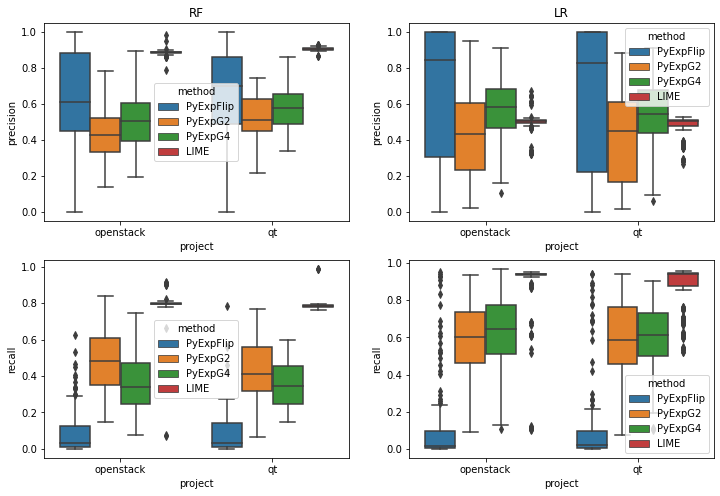

precision                                \
                                     count      mean       std       min   
global_model project   method                                              
LR           openstack LIME          376.0  0.498223  0.037699  0.318485   
                       PyExpFlip     203.0  0.664086  0.380448  0.000000   
                       PyExpG2       203.0  0.423420  0.228959  0.021433   
                       PyExpG4       203.0  0.568878  0.157481  0.101333   
             qt        LIME          254.0  0.474289  0.062677  0.266596   
                       PyExpFlip     148.0  0.634604  0.388686  0.000000   
                       PyExpG2       148.0  0.411549  0.241903  0.016361   
                       PyExpG4       148.0  0.528012  0.186132  0.061314   
RF           openstack LIME          198.0  0.885115  0.013093  0.788669   
                       PyExpFlip     113.0  0.611008  0.303529  0.000000   
                       PyExpG2       113.0  0.427751  0.130514  0.136298   
                       PyExpG4       113.0  0.507694  0.142719  0.194524   
             qt        LIME           48.0  0.904242  0.013760  0.863971   
                       PyExpFlip      43.0  0.652977  0.283097  0.000000   
                       PyExpG2        43.0  0.518000  0.128425  0.217442   
                       PyExpG4        43.0  0.575269  0.110597  0.339964   

                                                                          \
                                       25%       50%       75%       max   
global_model project   method                                              
LR           openstack LIME       0.495539  0.502553  0.508238  0.670213   
                       PyExpFlip  0.306250  0.844444  1.000000  1.000000   
                       PyExpG2    0.233228  0.431915  0.604087  0.947826   
                       PyExpG4    0.466209  0.583012  0.684340  0.911237   
             qt        LIME       0.473670  0.504014  0.510980  0.528754   
                       PyExpFlip  0.220735  0.826042  1.000000  1.000000   
                       PyExpG2    0.163862  0.447479  0.611827  0.881714   
                       PyExpG4    0.436529  0.544194  0.676890  0.913100   
RF           openstack LIME       0.882006  0.886276  0.889648  0.981250   
                       PyExpFlip  0.448276  0.611570  0.884615  1.000000   
                       PyExpG2    0.330739  0.428025  0.521144  0.782427   
                       PyExpG4    0.392758  0.503876  0.601961  0.891304   
             qt        LIME       0.899198  0.904299  0.908678  0.929526   
                       PyExpFlip  0.490007  0.696203  0.859127  1.000000   
                       PyExpG2    0.447696  0.508750  0.624681  0.746204   
                       PyExpG4    0.488031  0.578757  0.651853  0.860902   

                                 recall                                \
                                  count      mean       std       min   
global_model project   method                                           
LR           openstack LIME       376.0  0.910140  0.132379  0.102111   
                       PyExpFlip  203.0  0.109692  0.209357  0.000000   
                       PyExpG2    203.0  0.586143  0.198894  0.089888   
                       PyExpG4    203.0  0.627325  0.191691  0.107167   
             qt        LIME       254.0  0.880745  0.119508  0.520629   
                       PyExpFlip  148.0  0.116092  0.229987  0.000000   
                       PyExpG2    148.0  0.586387  0.205052  0.072886   
                       PyExpG4    148.0  0.596739  0.171446  0.098795   
RF           openstack LIME       198.0  0.794552  0.077385  0.072557   
                       PyExpFlip  113.0  0.092689  0.130576  0.000000   
                       PyExpG2    113.0  0.486998  0.158412  0.146832   
                       PyExpG4    113.0  0.354779  0.148307  0.074143   
             qt        LIME        48.0  0.79353

In [272]:
show_rq4_original_guidance_eval_result()